# Label Detection

## Axes Detection
This code gives a best estimate of the x and y axis (horizontal and vertical axes) for the plot/chart.

In [1]:
import cv2, imutils, re, xlsxwriter, json
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pathlib import Path
from matplotlib import rcParams
from pytesseract import Output

In [2]:
# Directory of images to run the code on
img_dir = 'processed_images'
data_dir = 'data'

# Directory to save the output images
save_dir = 'out'

In [3]:
with open('urldata.json') as handler:
    urldata = json.load(handler)

### Function to detect x-axis and y-axis for a plot

In [4]:
def findMaxConsecutiveOnes(nums) -> int:
    count = maxCount = 0
    
    for i in range(len(nums)):
        if nums[i] == 1:
            count += 1
        else:
            maxCount = max(count, maxCount)
            count = 0
                
    return max(count, maxCount)

In [5]:
def detectAxes(filepath, threshold=None, debug=False):
    if filepath is None:
        return None, None
    
    if threshold is None:
        threshold = 10
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[:, idx] < 200) for idx in range(width)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < width:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            break
            
        start_idx += 1
           
    yaxis = (maxindex, 0, maxindex, height)
    
    if debug:
        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(image)

        ax[1].plot(maxConsecutiveOnes, color = 'k')
        ax[1].axhline(y = max(maxConsecutiveOnes) - 10, color = 'r', linestyle = 'dashed')
        ax[1].axhline(y = max(maxConsecutiveOnes) + 10, color = 'r', linestyle = 'dashed')
        ax[1].vlines(x = maxindex, ymin = 0.0, ymax = maxConsecutiveOnes[maxindex], color = 'b', linewidth = 4)

        plt.show()

    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[idx, :] < 200) for idx in range(height)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < height:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            
        start_idx += 1
            
    cv2.line(image, (0, maxindex), (width, maxindex),  (255, 0, 0), 2)
    xaxis = (0, maxindex, width, maxindex)
    
    if debug:
        rcParams['figure.figsize'] = 15, 8

        fig, ax = plt.subplots(1, 1)
        ax.imshow(image, aspect = 'auto')
        
    return xaxis, yaxis

### Here we try to get text from the image using pytesseract

In [6]:
def getTextFromImageArray(image, mode):
    image_text = []
    
    if mode == 'y-text':
        image = cv2.transpose(image)
        image = cv2.flip(image, flipCode = 1)
        config = "-l eng --oem 1 --psm 11"
    elif mode == 'y-labels':
        config = "-l eng --oem 1 --psm 6 -c tessedit_char_whitelist=.0123456789"
    
    d = pytesseract.image_to_data(image, config = config, output_type = Output.DICT)
    
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
            
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

In [7]:
def getTextFromImage(filepath, bw=False, debug=False):
    image_text = []
    
    image = cv2.imread(filepath)
    height, width, _ = image.shape
        
    if bw:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # define range of black color in HSV
        lower_val = np.array([0, 0, 0])
        upper_val = np.array([179, 255, 179])

        # Threshold the HSV image to get only black colors
        mask = cv2.inRange(hsv, lower_val, upper_val)

        # Bitwise-AND mask and original image
        res = cv2.bitwise_and(image, image, mask = mask)

        # invert the mask to get black letters on white background
        image = cv2.bitwise_not(mask)
            
    d = pytesseract.image_to_data(image, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
     
    if bw:  
        image = cv2.imread(filepath)
        image_text = list(set(image_text))
        white_bg = 255 * np.ones_like(image)
        
        for text, (textx, texty, w, h) in image_text:
            roi = image[texty:texty + h, textx:textx + w]
            white_bg[texty:texty + h, textx:textx + w] = roi
            
        image_text = []
        d = pytesseract.image_to_data(white_bg, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
        n_boxes = len(d['text'])

        # Pick only the positive confidence boxes
        for i in range(n_boxes):

            if int(d['conf'][i]) >= 0:

                text = d['text'][i].strip()
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                image_text.append((d['text'][i], (x, y, w, h)))
        
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

### This function is to calculate the probable x-labels, y-labels and legend text

Here is the logic for the same

1. X-labels

    a. Check only the text boxes which are below the x-axis(, and to the right of y-axis).
    
    b. Run a line sweep from x-axis to the bottom of the image, and check when the sweeping line intersects with the maximum            number of text boxes.
    
    c. This maximum intersection gives all the x-labels



2. Y-labels:

    a. Check only the text boxes which are to the left of y-axis(, and to the top of x-axis).
    
    b. Run a line sweep from left end of the image to the y-axis position, and check when the sweeping line intersects with the        maximum number of text boxes.
    
    c. This maximum intersection gives all the y-labels


    
3. Legend text:
    
    a. Check only the text boxes in the remaining region (right to the y-axis and top of x-axis)
    
    b. Only Consider text boxes which have non-numeric text
    
    c. Run the sweeping line algorithm twice now - Once in the x-direction and the second time in the y-direction
    
    d. The maximum intersections gives all the legend texts.

In [8]:
def getProbableLabels(image, image_text, xaxis, yaxis):
    y_labels = []
    x_labels = []
    legends = []
    
    height, width, channels = image.shape
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
                    
        (x1, y1, x2, y2) = xaxis
        (x11, y11, x22, y22) = yaxis
            
        # To the left of y-axis and top of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == 1):
            y_labels.append((text, (textx, texty, w, h)))
            
        # To the right of y-axis and bottom of x-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == 1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            x_labels.append((text, (textx, texty, w, h)))
            
        # Top of x-axis and to the right of y-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            
            # Consider non-numeric only for legends
            if not bool(re.findall(r'\b[\d\.\d]+\b', text)):
                legends.append((text, (textx, texty, w, h)))
            
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, (text, rect) in enumerate(y_labels):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(y_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    y_labels = []
    for text, (textx, texty, w, h) in maxList:
        y_labels.append(text)
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
        
    # Get the x-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(y1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_labels):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    # Sort bounding rects by x coordinate
    def getYFromRect(item):
        return item[1]

    maxList.sort(key = getYFromRect)
    
    x_labels = []
    for text, (textx, texty, w, h) in maxList:
        x_labels.append(text)
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
    
    # Get possible legend text
    # For this, we need to search both top to
    # bottom and also from left to right.
    maxIntersection = 0
    maxList = []
    for i in range(y1):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
            
    for i in range(x11, width):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    legends = []
    #legendBoxes = []
    for text, (textx, texty, w, h) in maxList:
        legends.append(text)
    #    legendBoxes.append((textx, texty, w, h))
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    #legendBoxes = mergeRects(legendBoxes)
    
    #for (textx, texty, w, h) in legendBoxes:
    #    cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    return image, x_labels, y_labels, legends

In [9]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [10]:
def maskImageForwardPass(filepath, start_idx):
    image = cv2.imread(filepath)
    height, width, channels = image.shape
        
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    start_idx = 1
    try:
        while start_idx <= width:
            if sum(gray[:, start_idx] < 200) != 0:
                break
            else:
                start_idx += 1

        end_idx = start_idx
        while end_idx <= width:
            if sum(gray[:, end_idx] < 200) == 0:
                break
            else:
                end_idx += 1
    except IndexError:
        pass

    gray[:, 1:start_idx] = 255
    gray[:, end_idx:width] = 255
        
    return gray, start_idx, end_idx

In [11]:
def maskImageBackwardPass(filepath, end_idx):
    image = cv2.imread(filepath)
    height, width, channels = image.shape

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    while end_idx > 0:
        if sum(gray[:, end_idx] < 200) == 0:
            break
        else:
            end_idx -= 1
        
    gray[:, end_idx:width] = 255
        
    return gray

## Getting the Ratio for y-value matching 

In [12]:
def getRatio(filepath, xaxis, yaxis):
    list_text = []
    list_ticks = []
    
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, channels = image.shape

    # Make a backward pass to skip the ticks
    gray = maskImageBackwardPass(filepath, yaxis[0])

    # Processing the image so that the contours are drawn to labels and text
    ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)

    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    rects = [cv2.boundingRect(contour) for contour in contours]
    
    image_text = getTextFromImage(filepath, bw=True)
    image, y_labels = getProbableYLabels(image, rects, xaxis, yaxis)
    white_bg = 255 * np.ones_like(gray.copy())

    for (textx, texty, w, h) in y_labels:
        roi = gray[texty:texty + h, textx:textx + w]
        white_bg[texty:texty + h, textx:textx + w] = roi

    # Get y-labels
    y_labels_list = getTextFromImageArray(white_bg, 'y-labels')
    
    # Sort bounding rects by y coordinate
    def getYFromRect(item):
        return item[1][1]

    # Whiten y-labels and get y-text
    y_labels_list.sort(key = getYFromRect)
    
    # Get list of text and ticks
    list_text = []
    for text, (textx, texty, w, h) in y_labels_list:
        list_text.append(float(text))
        list_ticks.append(float(texty + h))
        
    text_sorted = (sorted(list_text))
    ticks_sorted  = (sorted(list_ticks))
    
    ticks_diff = ([ticks_sorted[i] - ticks_sorted[i-1] for i in range(1, len(ticks_sorted))])
    text_diff = ([text_sorted[i] - text_sorted[i-1] for i in range(1, len(text_sorted))])
    print("[get text-to-tick ratio] ticks_diff: {0}, text_diff: {1}".format(ticks_diff, text_diff))
    
    # Detected text may not be perfect! Remove the outliers.
    ticks_diff = reject_outliers(np.array(ticks_diff), m=1)
    text_diff = reject_outliers(np.array(text_diff), m=1)
    print("[reject_outliers] ticks_diff: {0}, text_diff: {1}".format(ticks_diff, text_diff))
    
    normalize_ratio = np.array(text_diff).mean() / np.array(ticks_diff).mean()

    return text_sorted, normalize_ratio

In [13]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [14]:
def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) <= m * np.std(data)]

## Writing to Excel workbook

In [15]:
def addToExcel(dataname, data, row):
    col = 0

    worksheet.write(row, col, dataname)
    for content in data:
        col += 1
        worksheet.write(row, col, content)

## Matching the ratio for final data extraction 

In [16]:
def mergeRects(contours):
    rects = []
    rectsUsed = []

    # Just initialize bounding rects and set all bools to false
    for cnt in contours:
        rects.append(cv2.boundingRect(cnt))
        rectsUsed.append(False)

    # Sort bounding rects by x coordinate
    def getXFromRect(item):
        return item[0]

    rects.sort(key = getXFromRect)

    # Array of accepted rects
    acceptedRects = []

    # Merge threshold for x coordinate distance
    xThr = 5
    yThr = 5

    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if (rectsUsed[supIdx] == False):

            # Initialize current rect
            currxMin = supVal[0]
            currxMax = supVal[0] + supVal[2]
            curryMin = supVal[1]
            curryMax = supVal[1] + supVal[3]

            # This bounding rect is used
            rectsUsed[supIdx] = True

            # Iterate all initial bounding rects
            # starting from the next
            for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

                # Initialize merge candidate
                candxMin = subVal[0]
                candxMax = subVal[0] + subVal[2]
                candyMin = subVal[1]
                candyMax = subVal[1] + subVal[3]

                # Check if x distance between current rect
                # and merge candidate is small enough
                if (candxMin <= currxMax + xThr):

                    if not nearbyRectangle((candxMin, candyMin, candxMax - candxMin, candyMax - candyMin),
                                           (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin), yThr):
                        break

                    # Reset coordinates of current rect
                    currxMax = candxMax
                    curryMin = min(curryMin, candyMin)
                    curryMax = max(curryMax, candyMax)

                    # Merge candidate (bounding rect) is used
                    rectsUsed[subIdx] = True
                else:
                    break

            # No more merge candidates possible, accept current rect
            acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])

    #for rect in acceptedRects:
    #    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)
    
    return acceptedRects

In [17]:
def nearbyRectangle(current, candidate, threshold):
    (currx, curry, currw, currh) = current
    (candx, candy, candw, candh) = candidate
    
    currxmin = currx
    currymin = curry
    currxmax = currx + currw
    currymax = curry + currh
    
    candxmin = candx
    candymin = candy
    candxmax = candx + candw
    candymax = candy + candh
    
    # If candidate is on top, and is close
    if candymax <= currymin and candymax + threshold >= currymin:
        return True
    
    # If candidate is on bottom and is close
    if candymin >= currymax and currymax + threshold >= candymin:
        return True
    
    # If intersecting at the top, merge it
    if candymax >= currymin and candymin <= currymin:
        return True
    
    # If intersecting at the bottom, merge it
    if currymax >= candymin and currymin <= candymin:
        return True
    
    # If intersecting on the sides or is inside, merge it
    if (candymin >= currymin and
        candymin <= currymax and
        candymax >= currymin and
        candymax <= currymax):
        return True
    
    return False

In [18]:
def euclidean(v1, v2):
    return sum((p - q) ** 2 for p, q in zip(v1, v2)) ** .5

def angle_between(p1, p2):
    
    deltaX = p1[0] - p2[0]
    deltaY = p1[1] - p2[1]

    #print(deltaX)
    #print(deltaY)
    return math.atan2(deltaY, deltaX) / math.pi * 180
    
def RectDist(rectA, rectB):
    (rectAx, rectAy, rectAw, rectAh) = rectA
    (rectBx, rectBy, rectBw, rectBh) = rectB
    
    angle = angle_between((rectAx + rectAw / 2, rectAy + rectAh / 2), (rectBx + rectBw / 2, rectBy + rectBh / 2))
    
    if (angle >= -5 and angle <= 5) or (angle <= -175 and angle >= -185) or (angle >= 175 and angle <= 185):
        if (rectBx > rectAx + rectAw):
            #print(rectA)
            #print(rectB)
            #print(angle)
            return euclidean([rectAx + rectAw / 2, rectAy + rectAh / 2], [rectBx + rectBw / 2, rectBy + rectBh / 2])
        else:
            return sys.maxsize
    else:
        return sys.maxsize

In [19]:
def getProbableYLabels(image, contours, xaxis, yaxis):
    y_labels = []
    
    height, width, channels = image.shape
    
    (x1, y1, x2, y2) = xaxis
    (x11, y11, x22, y22) = yaxis
    
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, rect in enumerate(contours):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(contours[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
                    
    return image, maxList

## Saving y-values in our data excel sheet 

In [20]:
import ast, cv2, re, sys
import math
import json


images = []
texts = []

def getYVal(img_dir):
    yValueDict = {}
    for index, path in enumerate(Path(img_dir).iterdir()):
        if path.name.endswith('.png') or path.name.endswith('.jpg'):
            filepath = img_dir + "/" + path.name
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            xaxis, yaxis = detectAxes(filepath)
            
            for (x1, y1, x2, y2) in [xaxis]:
                xaxis = (x1, y1, x2, y2)

            for (x1, y1, x2, y2) in [yaxis]:
                yaxis = (x1, y1, x2, y2)

            image_text = getTextFromImage(filepath, bw=True)
            img, x_labels, _, legends = getProbableLabels(img, image_text, xaxis, yaxis)
            try:
                list_text, normalize_ratio = getRatio(filepath, xaxis, yaxis)
                print("[{0}] path: {1}, ratio: {2}".format(index, path.name, normalize_ratio), end='\n\n')

                #rcParams['figure.figsize'] = 15, 8
                #plt.imshow(img)

                d = pytesseract.image_to_data(img, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
                n_boxes = len(d['text'])

                # Color detection
                h, w, _ = np.shape(img)

                image = img.reshape((h * w, 3))

                # Remove white and near-by pixels
                threshold = 5
                for r in range(255 - threshold, 256):
                    for g in range(255 - threshold, 256):
                        for b in range(255 - threshold, 256):
                            image = image[np.where((image != [r, g, b]).any(axis = 1))]

                values, counts = np.unique(image, axis = 0, return_counts = True)

                greater_counts = np.where(counts >= 100)
                values, counts = values[greater_counts], counts[greater_counts]

                sort_indices = np.argsort(-counts)
                values, counts = values[sort_indices], counts[sort_indices]

                groups = []
                groupcounts = []

                for idx, value in enumerate(values):
                    grouped = False

                    for groupid, group in enumerate(groups):
                        for member in group:
                            r, g, b = member
                            vr, vg, vb = value

                            if (abs(vr.astype(np.int16) - r.astype(np.int16)) <= 5 and
                                abs(vg.astype(np.int16) - g.astype(np.int16)) <= 5 and
                                abs(vb.astype(np.int16) - b.astype(np.int16)) <= 5):
                                group.append(value)
                                groupcounts[groupid] += counts[idx]
                                grouped = True
                                break

                        if grouped:
                            break

                    if not grouped:
                        groups.append([value])
                        groupcounts.append(counts[idx])

                groupcounts = np.array(groupcounts)
                sort_indices = np.argsort(-groupcounts)
                new_groups = [groups[i] for i in sort_indices]
                groups = new_groups
                
                for i in range(len(groups[:4])):

                    img = cv2.imread(img_dir + "/" + path.name)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    mask = None
                    for value in groups[i]:
                        COLOR_MIN = np.array([value[0], value[1], value[2]], np.uint8)
                        COLOR_MAX = np.array([value[0], value[1], value[2]], np.uint8)

                        if mask is None:
                            mask = cv2.inRange(img, COLOR_MIN, COLOR_MAX)
                        else:
                            mask = mask | cv2.inRange(img, COLOR_MIN, COLOR_MAX)

                    image = cv2.bitwise_and(img, img, mask = mask)
                    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, (3, 3))

                    edged = cv2.Canny(image, 0, 250)
                    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    contours = [contour for contour in contours if cv2.contourArea(contour) > 0.]

                    # Remove noisy ones!
                    if len(contours) == 0 or len(contours) > 100:
                        continue

                    contours = [cv2.approxPolyDP(contour, 3, True) for contour in contours]

                    rects = mergeRects(contours)
                    textBoxes = []
                    legends = []
                    
                    for rectBox in rects:
                        min_distance = sys.maxsize
                        closestBox = None
                        legendtext = None

                        for text, textBox in image_text:    
                            if RectDist(rectBox, textBox) < min_distance:
                                closestBox = textBox
                                min_distance = RectDist(rectBox, textBox)
                                legendtext = text

                        if closestBox is not None:
                            textBoxes.append(closestBox)

                        if legendtext is not None:
                            legends.append(legendtext)

                    list_len = []
                    
                    for rect in rects:
                        img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)
                        list_len.append(float(rect[3]))

                    # y-values will be a product of the normalize ratio and each length              
                    y_val = [round(l* normalize_ratio, 1) for l in list_len]

                    if path.name in yValueDict:
                        yValueDict[path.name].append([legends[-1]])
                        yValueDict[path.name].append(y_val)
                    else:
                        yValueDict[path.name] = [legends[-1]]
                        yValueDict[path.name].append(y_val)
                        
                    for box in textBoxes:
                        (x, y, w, h) = box
                        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

                    for (x1, y1, x2, y2) in [xaxis]:
                        cv2.line(img, (x1, y1), (x2, y2),  (0, 0, 255), 2)

                    for (x1, y1, x2, y2) in [yaxis]:
                        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        
            except Exception as e:
                print(e)
                continue
            
    return yValueDict

In [21]:
yValueDict = getYVal(img_dir)

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[0] path: 1-s2.0-S0016236118304502-main-Figure4-1.png, ratio: nan



C:\Users\dsand\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dsand\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\dsand\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\dsand\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\dsand\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\dsand\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:59: RuntimeWar

[get text-to-tick ratio] ticks_diff: [42.0, 41.0, 41.0, 42.0, 41.0, 41.0, 41.0, 42.0, 41.0, 41.0, 41.0], text_diff: [10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [41. 41. 41. 41. 41. 41. 41. 41.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[1] path: 1-s2.0-S0016236118318489-main-Figure2-1.png, ratio: 0.24390243902439024

[get text-to-tick ratio] ticks_diff: [39.0, 40.0, 39.0, 39.0, 40.0, 39.0, 40.0, 39.0, 40.0, 39.0, 39.0], text_diff: [10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [39. 39. 39. 39. 39. 39. 39.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[2] path: 1-s2.0-S0016236118318489-main-Figure3-1.png, ratio: 0.2564102564102564

[get text-to-tick ratio] ticks_diff: [38.0, 38.0, 39.0, 38.0, 39.0, 38.0, 39.0, 38.0, 39.0, 38.0, 39.0], text_diff: [10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [38. 38. 38. 38. 38. 38.], 

[get text-to-tick ratio] ticks_diff: [70.0, 70.0, 69.0, 70.0, 69.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [70. 70. 70.], text_diff: [20. 20. 20. 20. 20.]
[29] path: 1-s2.0-S0896844617309117-main-Figure3-1-2.png, ratio: 0.2857142857142857

[get text-to-tick ratio] ticks_diff: [125.0, 128.0], text_diff: [0.0, 10.0]
[reject_outliers] ticks_diff: [125. 128.], text_diff: [ 0. 10.]
[30] path: 1-s2.0-S0896844617309117-main-Figure6-1-1.png, ratio: 0.039525691699604744

list index out of range
[get text-to-tick ratio] ticks_diff: [47.0, 47.0, 46.0, 47.0, 47.0, 47.0, 46.0, 47.0], text_diff: [3.0, 7.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [47. 47. 47. 47. 47. 47.], text_diff: [5. 5. 5. 5. 5. 5.]
[31] path: 1-s2.0-S0896844617309117-main-Figure6-1-2.png, ratio: 0.10638297872340426

[get text-to-tick ratio] ticks_diff: [52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0], text_diff: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [52.

[get text-to-tick ratio] ticks_diff: [26.0, 25.0, 25.0, 26.0, 25.0, 25.0, 25.0, 26.0, 25.0], text_diff: [0.0, 10.0, 10.0, 0.0, 20.0, 10.0, 10.0, 10.0, 30.0]
[reject_outliers] ticks_diff: [25. 25. 25. 25. 25. 25.], text_diff: [10. 10. 10. 10. 10.]
[64] path: 1-s2.0-S0960852416306198-main-Figure2-1-2.png, ratio: 0.4

[get text-to-tick ratio] ticks_diff: [37.0], text_diff: [0.0]
[reject_outliers] ticks_diff: [37.], text_diff: [0.]
[65] path: 1-s2.0-S0960852416311816-main-Figure3-1-1.png, ratio: 0.0

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[66] path: 1-s2.0-S0960852416311816-main-Figure3-1-2.png, ratio: nan

[get text-to-tick ratio] ticks_diff: [28.0, 27.0, 28.0, 27.0, 29.0, 27.0, 28.0, 28.0, 27.0, 28.0, 28.0], text_diff: [0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [28. 28. 28. 28. 28. 28.], text_diff: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[67] path: 1-s2.0-S09608524163118

list index out of range
[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[98] path: 1-s2.0-S2211926418307756-main-Figure10-1-1.png, ratio: nan

list index out of range
[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[99] path: 1-s2.0-S2211926418307756-main-Figure10-1-2.png, ratio: nan

[get text-to-tick ratio] ticks_diff: [31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0], text_diff: [5.0, 5.0, 8.0, 2.0, 5.0, 5.0, 5.0, 5.0]
[reject_outliers] ticks_diff: [31. 31. 31. 31. 31. 31. 31. 31.], text_diff: [5. 5. 5. 5. 5. 5.]
[100] path: 1-s2.0-S2211926418307756-main-Figure3-1-1.png, ratio: 0.16129032258064516

list index out of range
[get text-to-tick ratio] ticks_diff: [47.0, 22.0, 9.0, 14.0, 33.0, 9.0, 14.0, 9.0, 17.0, 9.0, 12.0, 12.0, 5.0, 36.0], text_diff: [2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 3.0, 17.0, 5.0, 190.0, 290.0, 305.0]
[reject_outliers] ticks_diff: [22.  9. 14.  9. 14. 

[get text-to-tick ratio] ticks_diff: [56.0, 56.0, 56.0, 56.0, 56.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [56. 56. 56. 56. 56.], text_diff: [10. 10. 10. 10. 10.]
[128] path: acs.iecr.9b06655-Figure2-1-2.png, ratio: 0.17857142857142858

[get text-to-tick ratio] ticks_diff: [56.0, 56.0, 56.0, 56.0, 57.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [56. 56. 56. 56.], text_diff: [10. 10. 10. 10. 10.]
[129] path: acs.iecr.9b06655-Figure2-1-3.png, ratio: 0.17857142857142858

[get text-to-tick ratio] ticks_diff: [56.0, 56.0, 56.0, 56.0, 57.0], text_diff: [10.0, 10.0, 10.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [56. 56. 56. 56.], text_diff: [10. 10. 10. 10. 10.]
[130] path: acs.iecr.9b06655-Figure2-1-4.png, ratio: 0.17857142857142858

[get text-to-tick ratio] ticks_diff: [], text_diff: []
[reject_outliers] ticks_diff: [], text_diff: []
[131] path: acssuschemeng.6b00226-Figure2-1.png, ratio: nan

[get text-to-tick ratio] ticks_

[get text-to-tick ratio] ticks_diff: [37.0, 37.0, 36.0, 36.0, 37.0, 36.0, 37.0, 37.0, 37.0], text_diff: [10.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 120.0]
[reject_outliers] ticks_diff: [37. 37. 37. 37. 37. 37.], text_diff: [10.  0. 10. 10. 10. 10. 10. 10.]
[159] path: ep.12172-Figure3-1.png, ratio: 0.23648648648648649

[get text-to-tick ratio] ticks_diff: [41.0, 41.0, 40.0, 81.0, 40.0, 41.0, 40.0, 41.0], text_diff: [0.0, 10.0, 10.0, 10.0, 10.0, 30.0, 10.0, 10.0]
[reject_outliers] ticks_diff: [41. 41. 40. 40. 41. 40. 41.], text_diff: [10. 10. 10. 10. 10. 10.]
[160] path: ep.12172-Figure4-1.png, ratio: 0.24647887323943662

[get text-to-tick ratio] ticks_diff: [66.0, 64.0, 65.0, 64.0, 66.0], text_diff: [20.0, 20.0, 20.0, 20.0, 20.0]
[reject_outliers] ticks_diff: [65.], text_diff: [20. 20. 20. 20. 20.]
[161] path: Phusunti2017_Article_SubcriticalWaterHydrolysisOfMi-Figure2-1.png, ratio: 0.3076923076923077



number of contours:  0
0 Aqueous
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Biocrude']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S0016236118304502-main-Figure4-1.png
x-labels     :   []
y-text       :   []
y-labels     :   []
legends      :   ['€', 'Ss', 'sé', '&', 's', '¥', '&', 's', '&', '+']
Y- Values    :   Aqueous [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Biocrude'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

number of contours:  14
0 residue
1 [111.5, 102.7, 100.7, 2.7, 103.7, 2.7, 2.2, 20.5, 0.5, 2.9, 3.4, 105.4, 1.0]
file name    :   1-s2.0-S0016236118318489-main-Figure2-1.png
x-labels     :   ['Water', 'HCOOH', 'CH,COOH', 'HCI', 'H,SO,', 'Ethyl', 'Acetone', 'Ethanol', 'Methanol']
y-text       :   ['Liquefaction', 'yields', '(wt.']
y-labels     :   ['10', '100', '

number of contours:  4
0 [Aromatic
1 [0.2, 16.3, 16.2, 2.7, 0.2]
2 ['Heterocyclic']
3 [16.3, 16.3, 2.5]
4 ['12.4%']
5 [0.6, 2.5, 0.2, 0.2, 0.2, 0.2, 0.2, 16.3, 16.2]
6 ['134%']
7 [0.4, 2.3, 0.2, 0.2, 0.2, 0.2, 16.3, 16.0]
file name    :   1-s2.0-S0165237018301529-main-Figure5-1-3.png
x-labels     :   ['20', '40', '60', '80', '100']
y-text       :   ['time', '[min]', ')']
y-labels     :   ['5', '3', '8', '830']
legends      :   ['[I', '[i', 'hydrocarbons', 'compounds', 'Nitriles', 'Amides', 'Heterocyclic', '[Aromatic', 'HJ', 'HB', 'Amines', 'compounds', 'Aliphatic', '[J']
Y- Values    :   [Aromatic [0.2, 16.3, 16.2, 2.7, 0.2] ['Heterocyclic'] [16.3, 16.3, 2.5] ['12.4%'] [0.6, 2.5, 0.2, 0.2, 0.2, 0.2, 0.2, 16.3, 16.2] ['134%'] [0.4, 2.3, 0.2, 0.2, 0.2, 0.2, 16.3, 16.0]

number of contours:  1
0 £0
1 [4.4, 1.5, 128.0, 80.6, 49.6, 4.4, 7.4]
2 ['50']
3 [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 169.4, 0.7, 1.5, 3.0, 0.7, 1.5, 0.7, 4.4, 1.5, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.5, 0.7, 0.7, 0.

number of contours:  7
0 360
1 [0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3, 0.3, 1.8, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 0.9, 2.5, 0.3, 0.6, 0.3, 0.3, 0.6, 0.3, 4.9, 0.3, 0.3, 0.3, 0.3, 0.3, 1.5, 0.3, 2.2, 0.3, 0.3, 1.5]
file name    :   1-s2.0-S0896844617309117-main-Figure2-1-2.png
x-labels     :   ['300', '320', '340', '360']
y-text       :   ['Vield@wt%:']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['(b)']
Y- Values    :   360 [0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3, 0.3, 1.8, 0.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 0.9, 2.5, 0.3, 0.6, 0.3, 0.3, 0.6, 0.3, 4.9, 0.3, 0.3, 0.3, 0.3, 0.3, 1.5, 0.3, 2.2, 0.3, 0.3, 1.5]

number of contours:  7
0 us
1 [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.9, 0.3, 11.9, 0.3, 0.3, 0.3, 0.3, 1.7, 11.9, 1.4, 1.7, 0.3, 0.3, 2.6, 0.3, 2.6, 0.3, 11.6, 0.3, 6.4, 0.3, 0.3, 1.4, 0.3, 1.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 10.7, 0.3, 10.4, 0.3, 0.3, 1.2, 0.3, 0.3, 7.8, 0.3, 0.3, 1.2, 0.3, 2.6, 11.6, 0.3, 6.1

number of contours:  11
0 Nyaz03
1 [0.2, 1.0, 0.4, 0.2, 0.2, 0.6, 0.4, 0.6, 1.0, 1.2, 0.2, 1.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 0.4, 0.2, 1.0, 0.2, 1.2, 0.2, 0.2, 0.4, 0.4, 0.2, 0.2, 0.2, 15.4, 0.2, 0.2, 1.5, 11.1, 1.0, 0.2, 0.4, 1.3, 0.4, 1.5, 0.2, 0.2, 1.3, 0.2, 1.5, 0.2, 0.2, 1.0, 0.2, 0.4, 0.2, 0.2, 0.2, 1.0, 0.2, 0.2, 0.4, 1.2, 0.4, 0.2, 0.2, 10.0, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.2, 0.2]
2 ['Nyaz03']
3 [0.4, 9.0, 1.3, 0.6]
4 ['Nyaz03']
5 [0.4, 0.4, 0.2, 0.2, 0.2, 1.2, 0.2, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.2, 0.2, 15.4, 0.4, 11.3, 0.2, 0.2, 0.4, 1.2, 1.2, 0.6, 1.3, 0.4, 0.4, 0.4, 0.6, 1.0, 0.4, 0.2, 0.2, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.6, 0.2, 0.2, 1.2, 0.2, 0.4, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 1.3, 1.0, 0.6, 1.3, 0.2, 0.4, 0.2, 0.2, 0.2, 0.4, 0.8, 0.2, 0.4, 0.2, 0.4, 0.2, 0.6]
6 ['Nyaz03']
7 [0.4, 0.6, 0.4, 0.4, 1.5, 0.8, 0.4, 10.2, 1.2, 10.2, 0.4, 0.2, 0.4, 1.3, 10.2, 1.0, 0.6, 1.5, 1.2, 0.4, 14.4, 0.4, 0.4, 1.5, 1.

number of contours:  12
0 n
1 [3.1, 0.4, 19.3, 2.0, 0.4, 1.2, 4.7, 2.4, 5.1, 3.5, 7.9, 10.6, 1.2, 0.8, 2.4, 2.4, 6.3, 68.8, 2.4, 2.0, 4.3, 10.2]
2 ['8']
3 [63.7, 2.0, 0.4, 0.8, 0.8]
4 ['Loss']
5 [0.4, 0.4, 0.4, 2.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 10.2, 67.6, 20.0, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 1.2, 0.4, 0.4, 2.8, 0.4, 2.8, 1.2, 62.5, 0.4, 2.0, 0.4, 0.4, 2.4, 0.4, 0.4, 2.0, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 2.8, 2.0, 0.4]
file name    :   1-s2.0-S0960852414014412-main-Figure3-1-2.png
x-labels     :   ['oc', '350°C']
y-text       :   ['‘Yield,', 'wt.', '%']
y-labels     :   ['100', '90', '80', '70', '60', '50', '40', '30', '0', '10', '0']
legends      :   ['Loss', 'BResidue', 'phase', 'AWater']
Y- Values    :   n [3.1, 0.4, 19.3, 2.0, 0.4, 1.2, 4.7, 2.4, 5.1, 3.5, 7.9, 10.6, 1.2, 0.8, 2.4, 2.4, 6.3, 68.8, 2.4, 2.0, 4.3, 10.2] ['8'] [63.7, 2.0, 0.4, 0.8, 0.8] ['Loss'] [0.4, 0.4, 0.4, 2.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 10.2, 67.6, 20.0, 0.4, 0.4

number of contours:  7
0 Lipi
1 [1.3, 0.3, 2.3, 1.5, 0.3, 4.4, 2.3, 4.4, 1.3, 1.0, 2.3, 6.4]
2 ['30']
3 [0.5, 0.8, 0.5, 0.3, 0.8, 0.3, 0.3, 0.3, 31.8, 0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3]
4 ['Carbohydrate']
5 [4.1, 4.4, 0.3, 2.3, 2.3, 2.8, 9.5, 5.4, 3.3, 0.3, 6.4, 2.6]
file name    :   1-s2.0-S096085241730038X-main-Figure3-1.png
x-labels     :   ['4', '6', '8', '10', '12', '14', '16', '18,', '20', '22', '24', '26', '28', '30']
y-text       :   ['Percentage', '(%)']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['Carbohydrate', 'Lipid', 'Protein', 'ME', 'Algae', 'Protein']
Y- Values    :   Lipi [1.3, 0.3, 2.3, 1.5, 0.3, 4.4, 2.3, 4.4, 1.3, 1.0, 2.3, 6.4] ['30'] [0.5, 0.8, 0.5, 0.3, 0.8, 0.3, 0.3, 0.3, 31.8, 0.3, 0.3, 0.3, 1.5, 0.3, 0.3, 0.3] ['Carbohydrate'] [4.1, 4.4, 0.3, 2.3, 2.3, 2.8, 9.5, 5.4, 3.3, 0.3, 6.4, 2.6]

number of contours:  7
0 12
1 [0.8, 1.2, 3.1, 0.4, 0.4, 1.5, 1.5, 0.4, 1.9, 2.3, 4.2, 4.6, 1.2, 0.8, 1.5, 2.7, 2.7, 0.8, 1.5, 3.5, 0.4, 0.4, 0.8, 1.

number of contours:  7
0 BO
1 [33.7, 36.8, 3.2, 42.8, 39.3, 36.1, 32.6, 30.9]
2 ['sk']
3 [39.3, 0.7, 35.8, 32.6, 4.9, 32.3, 28.4, 26.3, 22.5]
file name    :   1-s2.0-S0960852418306631-main-Figure2-1.png
x-labels     :   ['10.', '20', '30', '40', '50,', '60', '120']
y-text       :   ['Yield', '(%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['HM', 'BO', 'sk', 'BGA']
Y- Values    :   BO [33.7, 36.8, 3.2, 42.8, 39.3, 36.1, 32.6, 30.9] ['sk'] [39.3, 0.7, 35.8, 32.6, 4.9, 32.3, 28.4, 26.3, 22.5]

number of contours:  7
0 GA
1 [42.8, 40.7, 76.2, 4.8, 30.7, 39.3, 43.1, 48.6]
2 ['MSR']
3 [32.1, 36.6, 4.8, 39.0, 41.0, 38.3, 31.7, 31.4]
4 ['GA']
5 [22.1, 19.3, 20.7, 24.8, 4.1, 20.0, 22.8, 16.6]
file name    :   1-s2.0-S0960852418306631-main-Figure3-1.png
x-labels     :   ['vw', 'V2', '13', '“4', 'vs', '1/6,', 'V7']
y-text       :   ['Yield', '(%)']
y-labels     :   ['100', '80', '60', '40', '20', '0']
legends      :   ['GA', 'Gmso', 'MSR']
Y- Values    :   GA [42.8, 

number of contours:  0
0 &
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Bio-oil']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['WSP']
5 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   1-s2.0-S2211926415300345-main-Figure7-1-2.png
x-labels     :   []
y-text       :   []
y-labels     :   []
legends      :   ['Bio-oil', 'mGas', '&', 'WSP', 'Char', 'UA/C', 'b)']
Y- Values    :   & [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Bio-oil'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['WSP'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

number of contours:  7
0 Reus
1 [100.0, 100.0, 100.0, 96.2, 92.4, 67.6]
file name    :   1-s2.0-S2211926417305477-main-Figure1-1.png
x-labels     :   ['<maoawwe']
y-text       :   ['Species', 'Abundance', '[wt', '%]']
y-labels     :   ['100', '80', '60', '40', '20']
legends      :   ['Reus']
Y- Values    :   Reus [100.0, 100.0, 100.0, 96.2, 92.4, 67.6]

number of contours:  0
0 Aa

number of contours:  0
0 ,
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['Gas']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
4 ['Solid']
5 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   acs.energyfuels.5b00321-Figure1-1.png
x-labels     :   ['=', 'es', 'Ko', '~', '>', '$e"', 'we']
y-text       :   []
y-labels     :   []
legends      :   []
Y- Values    :   , [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Gas'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] ['Solid'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

number of contours:  0
0 asoc
1 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 ['asoc']
3 [nan, nan, nan, nan, nan, nan, nan, nan, nan]
file name    :   acs.energyfuels.6b01229-Figure3-1.png
x-labels     :   ['12', '16', '19', '30']
y-text       :   []
y-labels     :   []
legends      :   []
Y- Values    :   asoc [nan, nan, nan, n

number of contours:  7
0 sp.
1 [0.4, 0.2, 0.2, 0.2, 0.2, 7.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 13.6, 0.2, 0.5, 0.2, 0.2, 18.9]
2 ['char']
3 [0.9, 1.1, 0.2, 0.5, 0.9, 0.2, 0.2, 0.2, 1.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 27.5, 0.2, 1.1, 27.5, 0.2, 0.2, 1.8]
file name    :   acs.iecr.9b06655-Figure1-1-4.png
x-labels     :   ['25:75', '50:50', '75:25']
y-text       :   ['Yield', '(dwt.%']
y-labels     :   ['50', '40', '30', '20', '10', '0']
legends      :   ['SCG/C.', 'sp.', 'char', '(d)']
Y- Values    :   sp. [0.4, 0.2, 0.2, 0.2, 0.2, 7.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 13.6, 0.2, 0.5, 0.2, 0.2, 18.9] ['char'] [0.9, 1.1, 0.2, 0.5, 0.9, 0.2, 0.2, 0.2, 1.4, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.9, 0.2, 27.5, 0.2, 1.1, 27.5, 0.2, 0.2, 1.8]

number of contours:  7
0 75:25
1 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 1.4, 0.2, 0.2, 0.2, 18.6, 0.2, 0.2, 0.2, 0.2, 0.2, 1.6, 0.2, 0.2, 0.2, 0.2, 0.2

number of contours:  11
0 -
1 [4.6, 4.6, 46.9, 63.4, 62.3, 66.0, 46.9, 50.6, 2.6, 2.3]
2 ['5']
3 [0.3, 36.0, 20.0, 2.3, 2.3, 0.6, 4.6]
file name    :   acssuschemeng.7b01473-Figure2-1.png
x-labels     :   ['25', '150', '160', '170', '180', '190', '200', '225', '230', '2758', '300']
y-text       :   ['Carbohydrate', 'recovery', '(“%)']
y-labels     :   ['90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['wm', 'Wa', 'EO', 'Wi', 'Ua']
Y- Values    :   - [4.6, 4.6, 46.9, 63.4, 62.3, 66.0, 46.9, 50.6, 2.6, 2.3] ['5'] [0.3, 36.0, 20.0, 2.3, 2.3, 0.6, 4.6]

number of contours:  9
0 Solids
1 [3.2, 1.5]
file name    :   Brilman2017_Article_HydrothermalCo-liquefactionOfM-Figure3-1-3.png
x-labels     :   ['B', 'Linear', 'Model', 'Exp.', '250°C', 'E', 'Linear', 'Model', 'm', 'Exp.', '350°']
y-text       :   ['Product', 'yield', '[w%]', 'oO']
y-labels     :   ['60', '50', '40', '30', '20', '10', '0']
legends      :   []
Y- Values    :   Solids [3.2, 1.5]

number of contour

number of contours:  12
0 (]
1 [2.7, 33.2, 1.6, 37.6, 0.8, 1.6, 2.4, 2.7, 47.8, 0.3, 1.1, 37.6, 22.4]
file name    :   ef201415s-Figure5-1-1.png
x-labels     :   ['15', '30', '60']
y-text       :   ['Yield', '(wt.%)']
y-labels     :   ['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
legends      :   ['[fj', '(]', 'Water', '[I]', 'Gas', 'Solid', 'soluble', 'residue', 'Oil', 'organics']
Y- Values    :   (] [2.7, 33.2, 1.6, 37.6, 0.8, 1.6, 2.4, 2.7, 47.8, 0.3, 1.1, 37.6, 22.4]

number of contours:  12
0 (]
1 [0.3, 0.8, 30.0, 2.4, 2.1, 29.5, 2.6, 24.2, 1.1, 1.1, 0.5, 21.1, 1.3]
2 ['Oil']
3 [0.5, 1.1, 0.3, 1.1, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 2.1, 0.3, 1.6, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.8, 0.8, 0.8, 14.7, 0.3, 0.3, 1.1, 0.3, 0.3, 0.3, 0.8, 0.8, 0.3, 0.3, 0.8, 0.3, 1.1, 0.3, 0.3, 0.8, 2.1, 0.3, 10.5, 0.3, 0.3, 2.4, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.5, 0.3, 0.3, 0.3, 0.8, 0.3, 0.8, 0.3, 0.8, 17.4, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.3, 0.3, 2.4, 0.3, 0.3, 0.3, 0.3, 1.1, 0.3, 

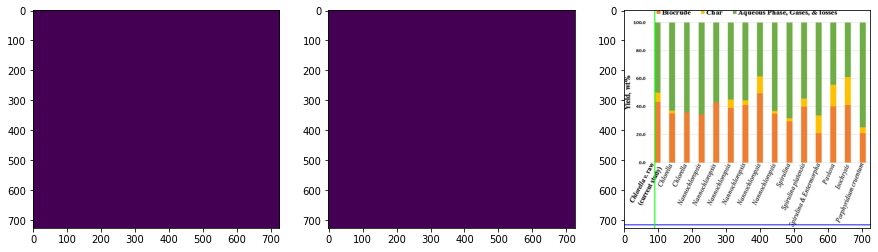

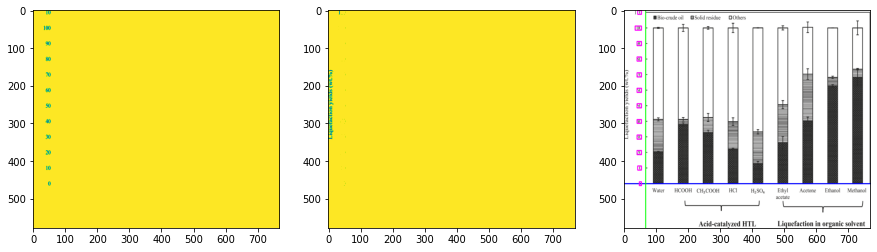

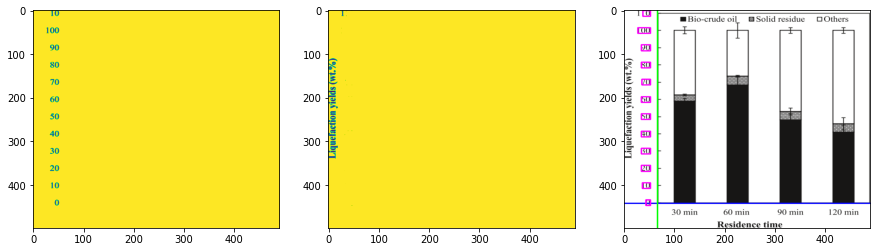

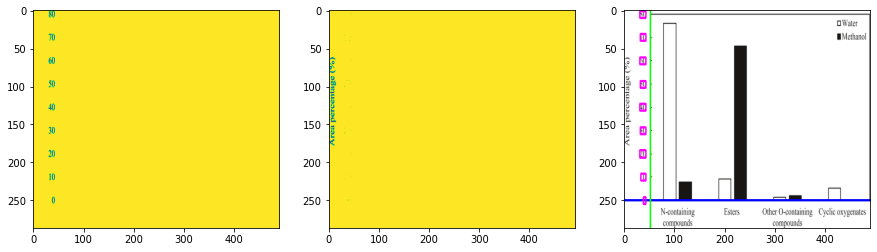

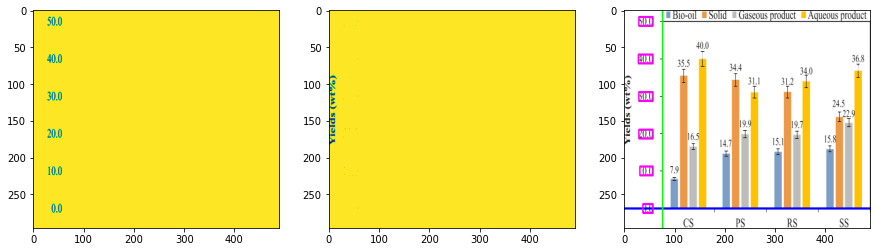

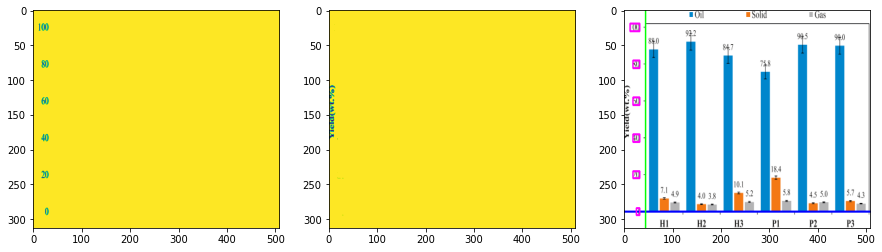

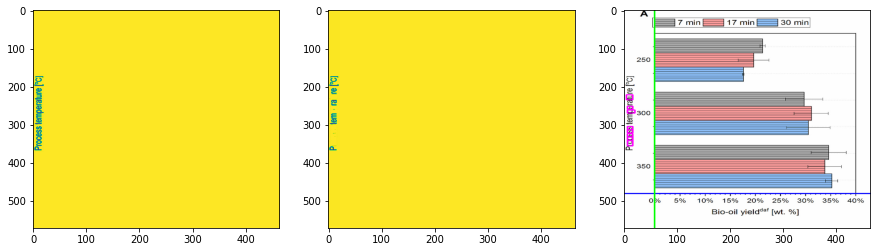

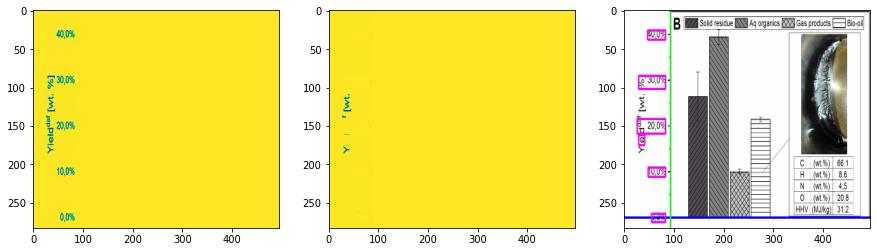

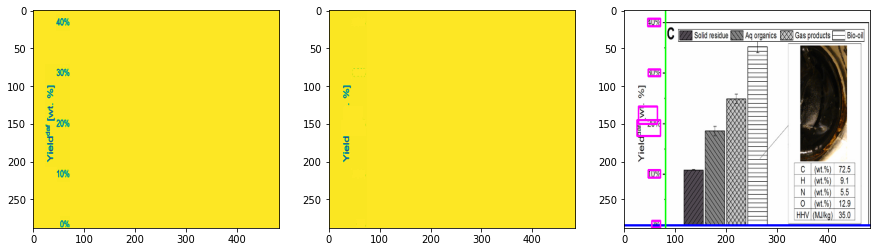

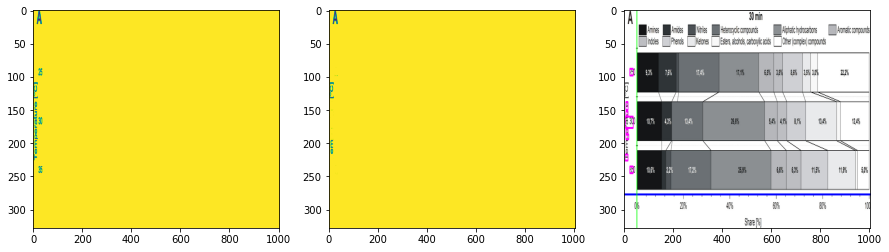

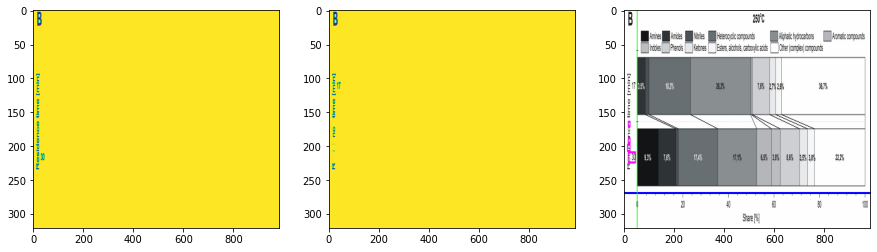

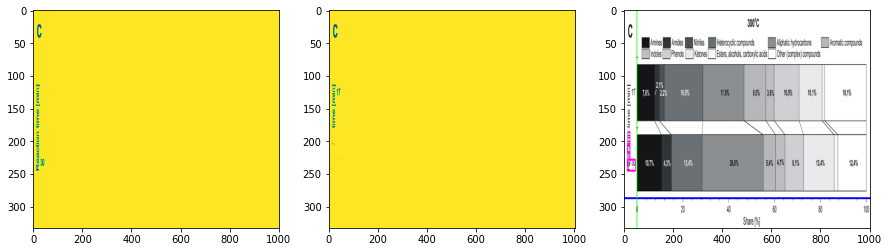

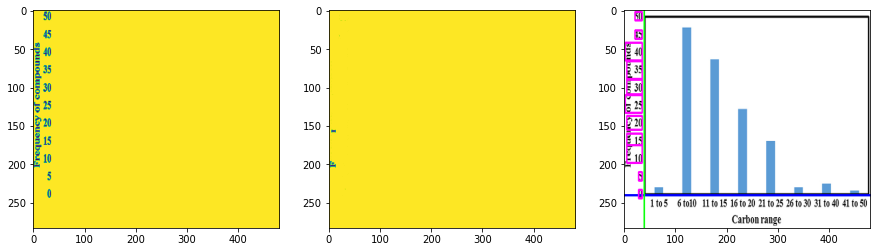

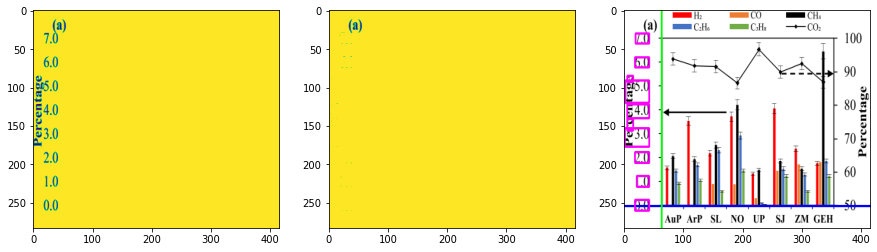

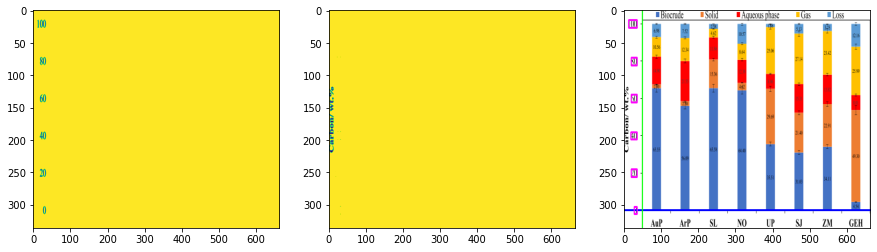

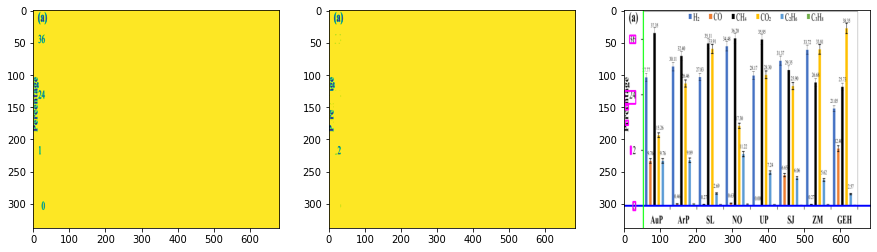

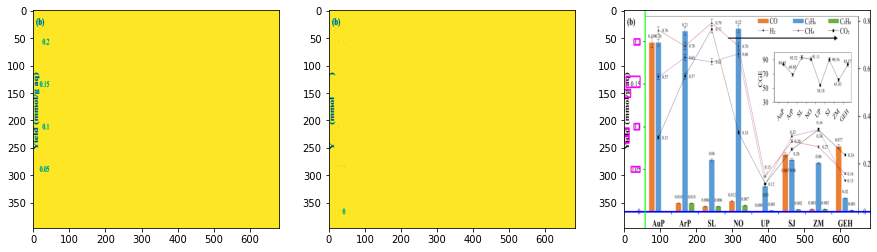

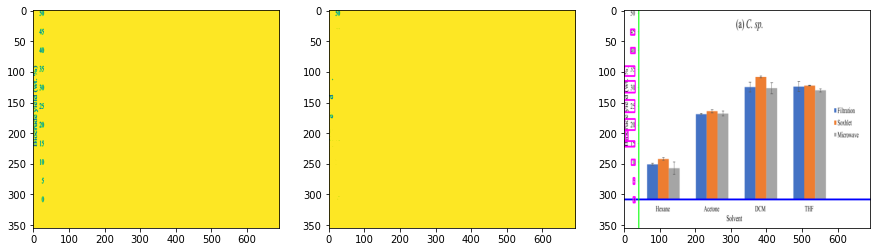

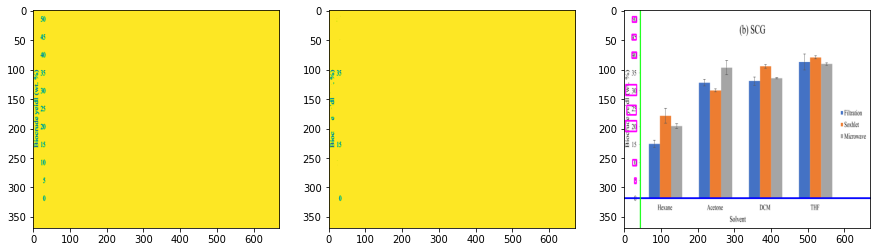

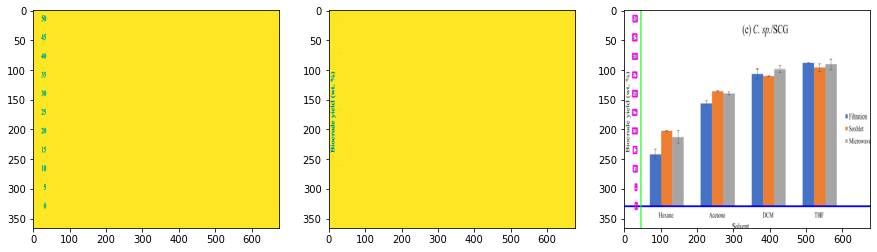

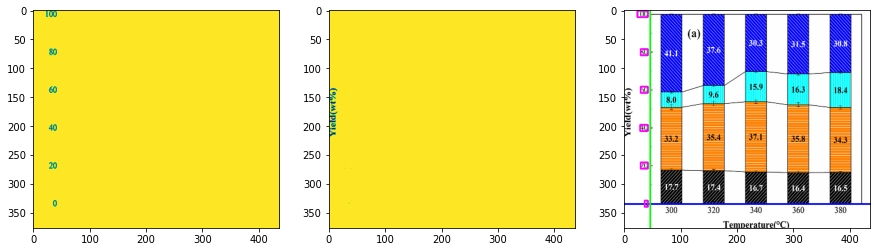

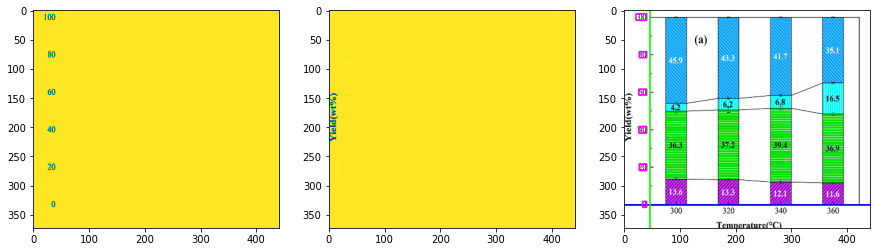

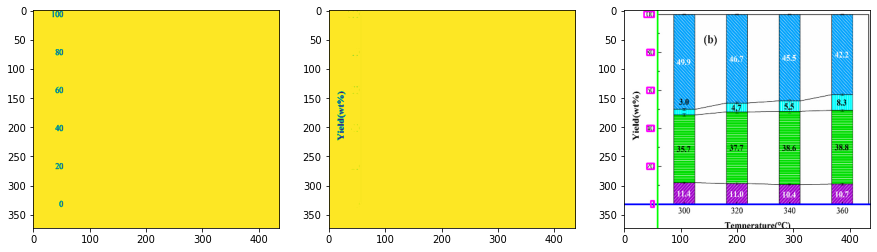

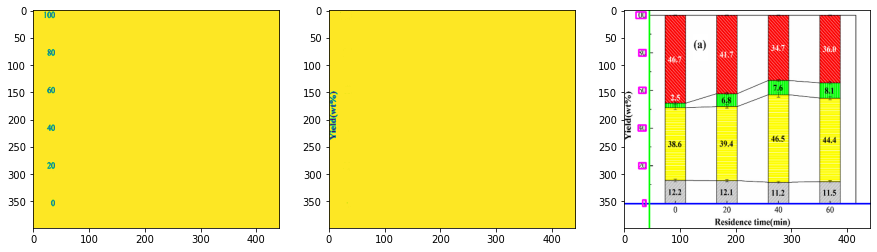

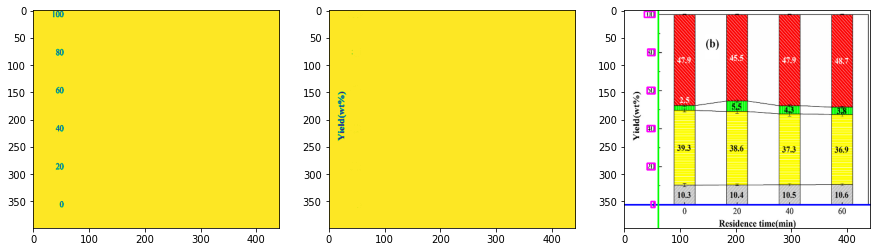

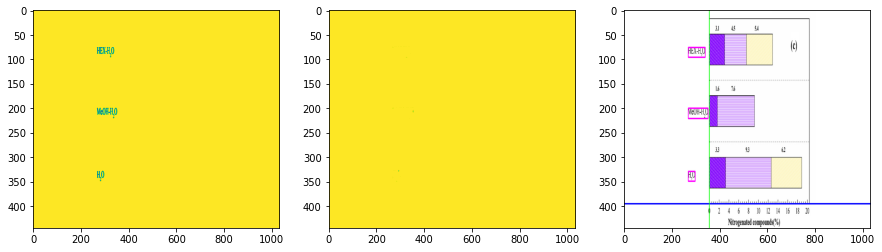

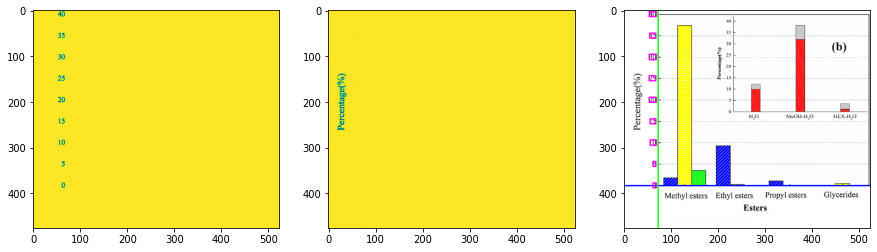

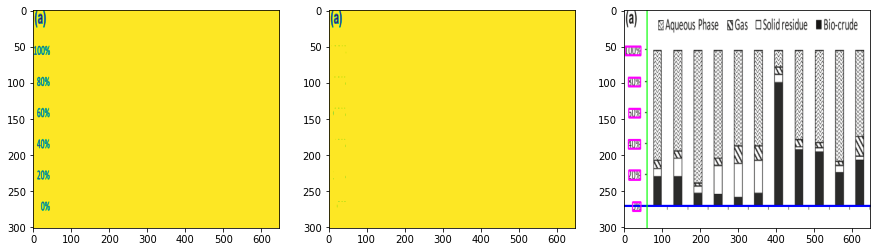

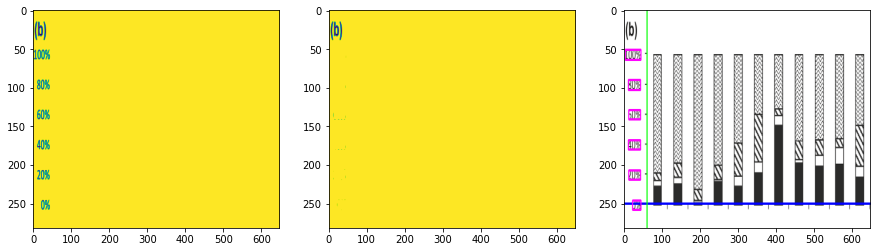

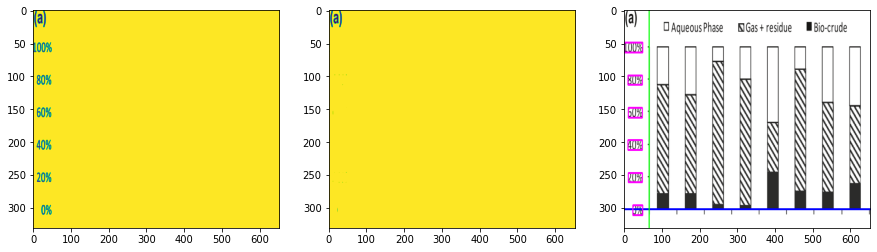

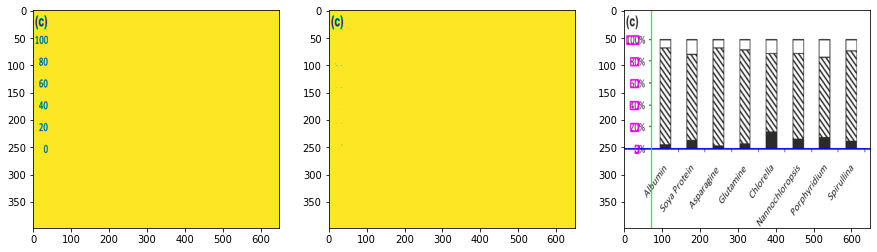

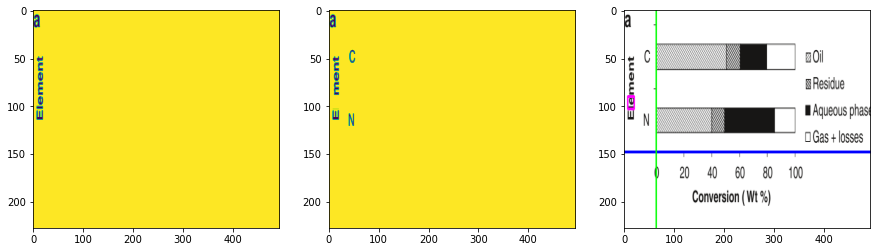

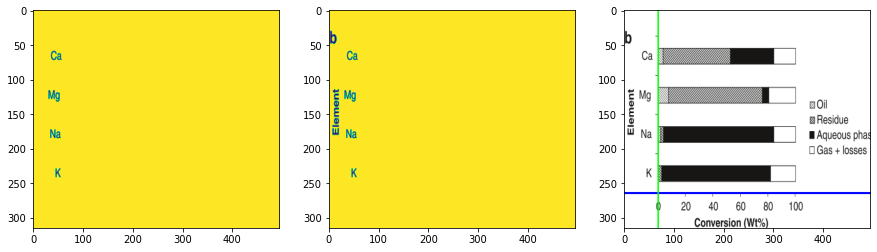

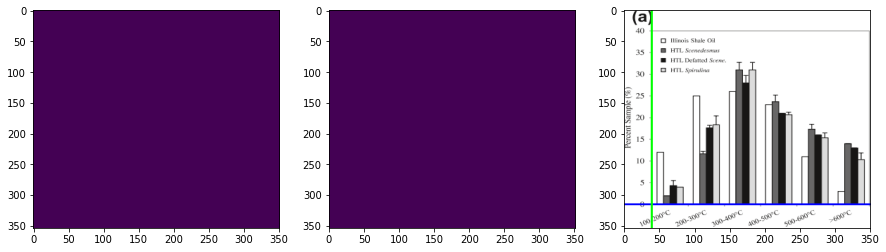

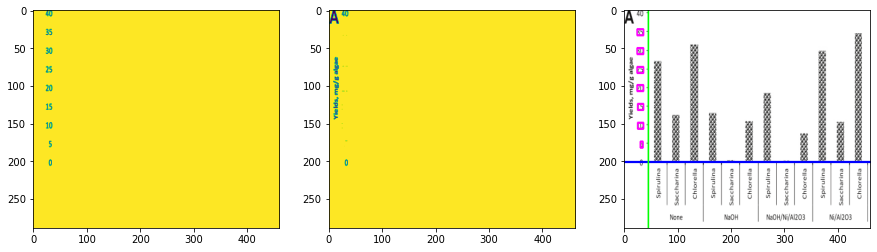

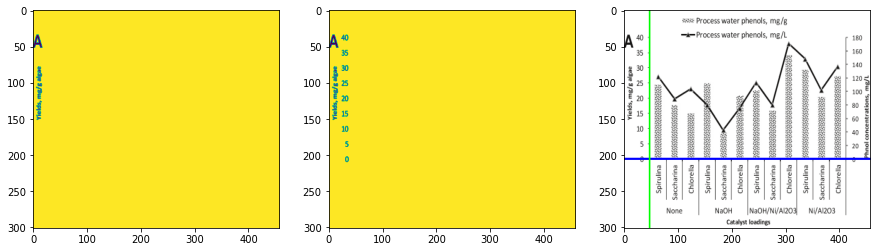

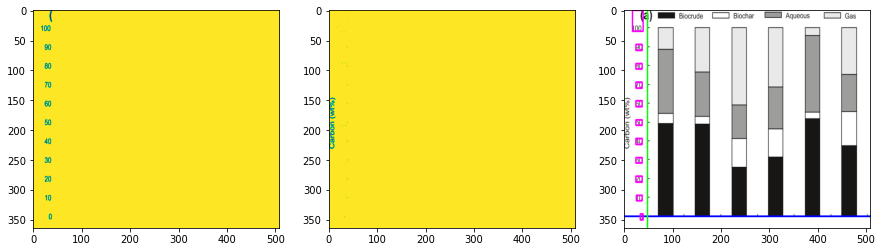

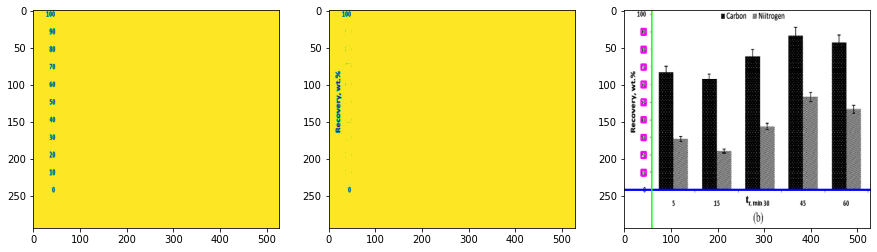

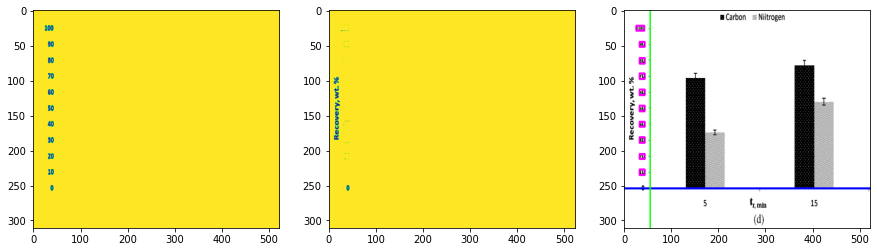

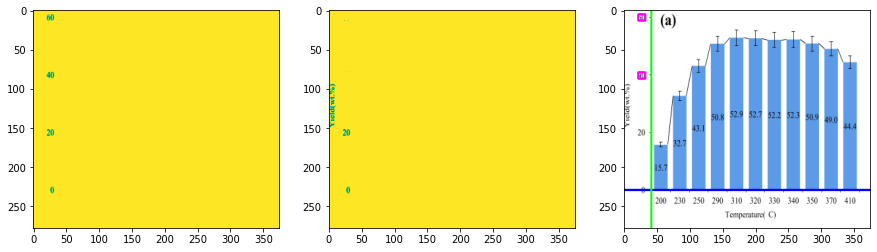

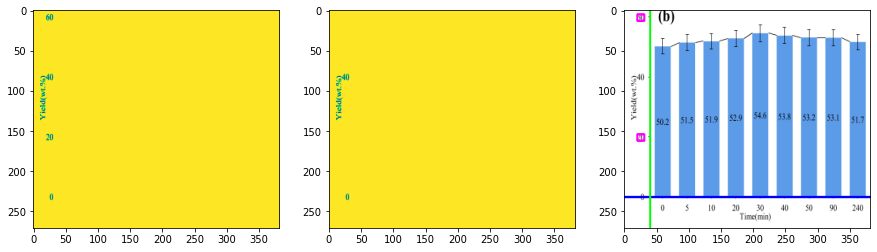

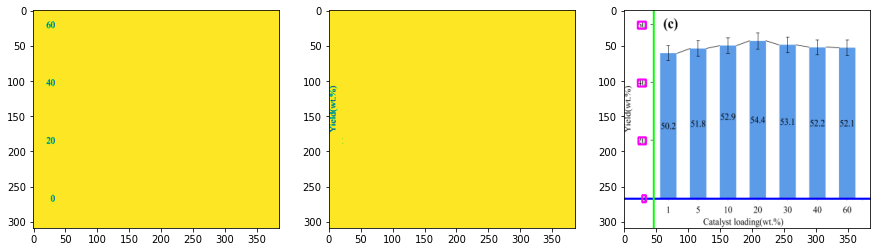

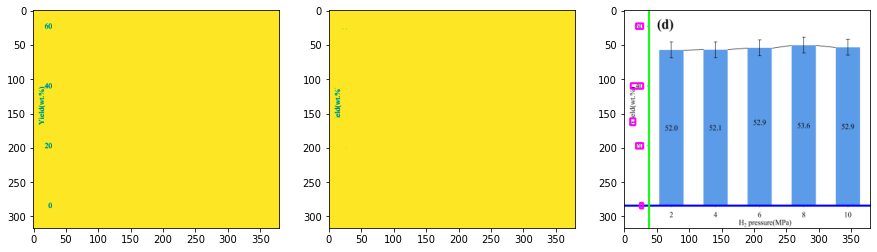

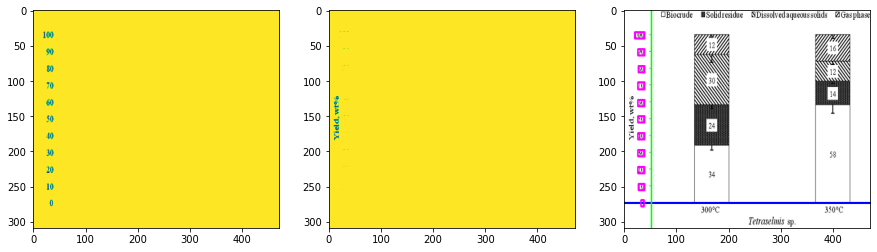

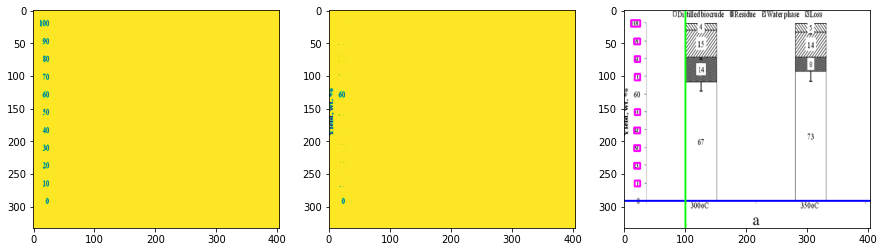

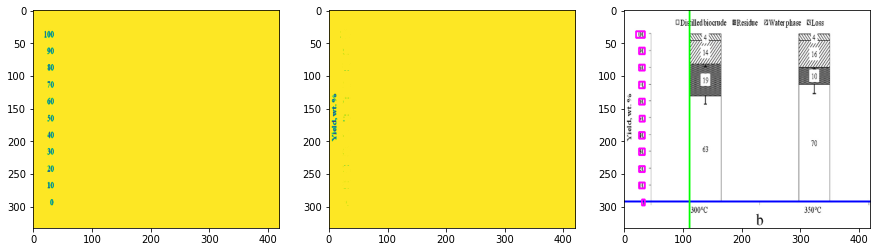

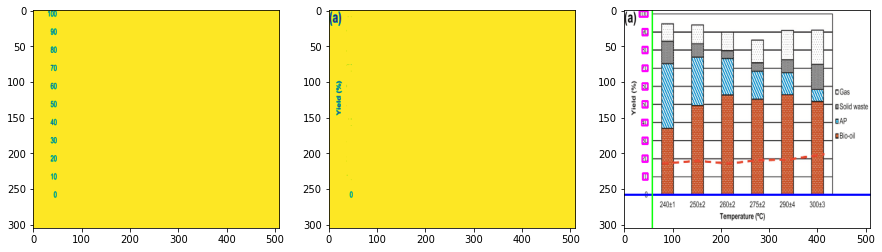

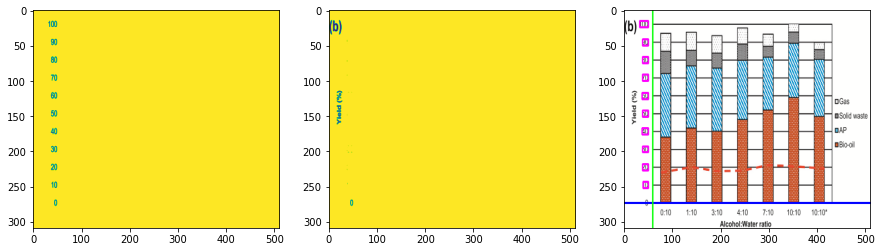

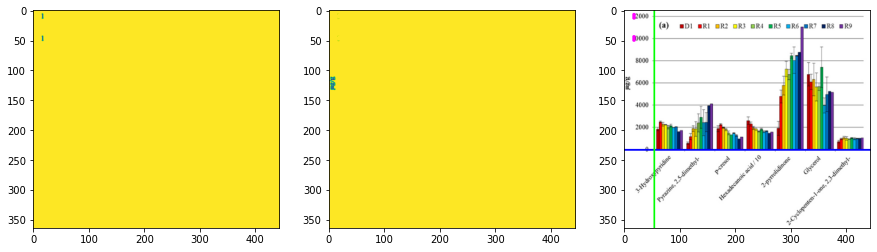

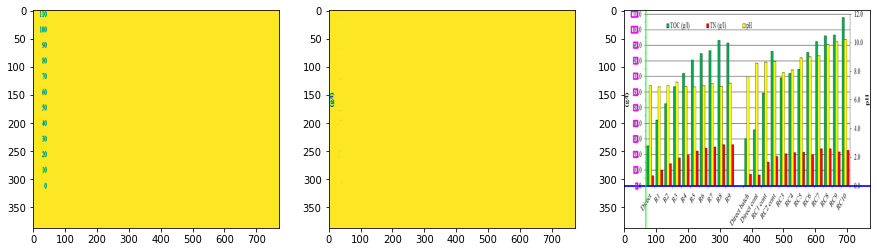

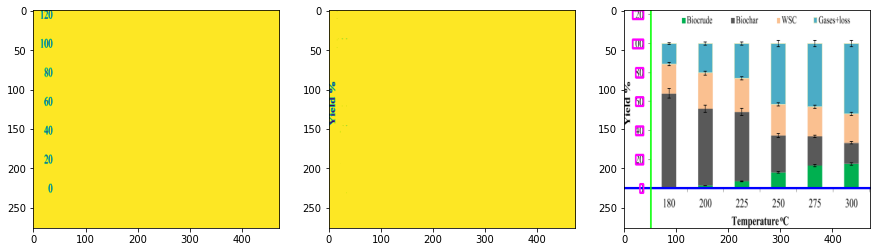

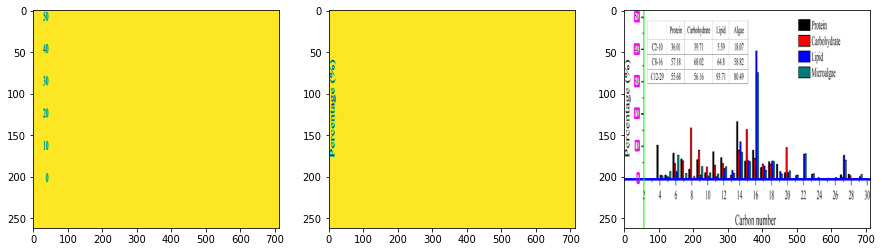

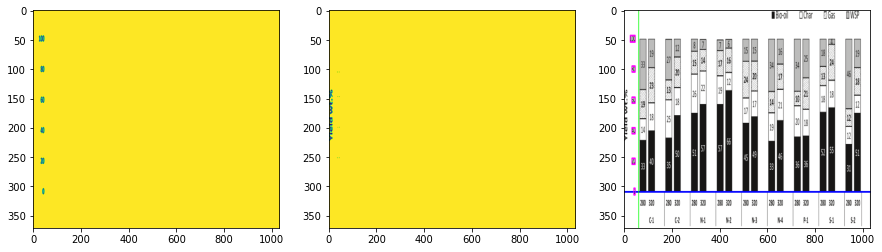

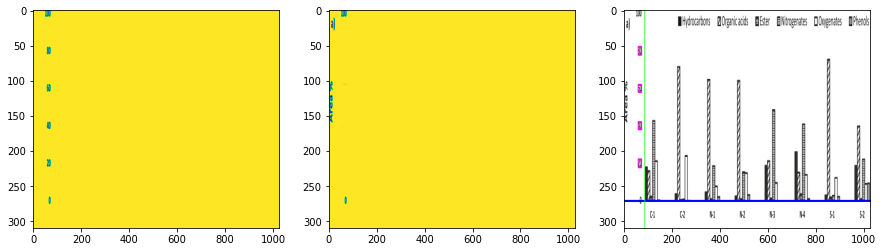

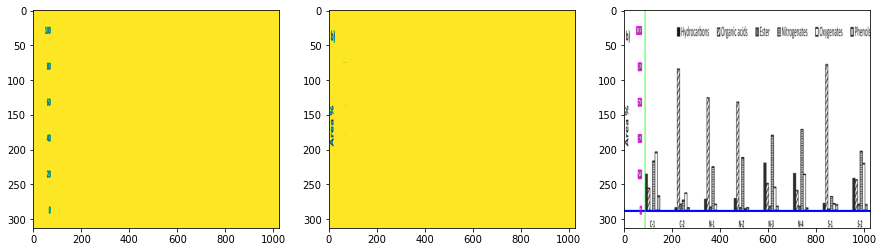

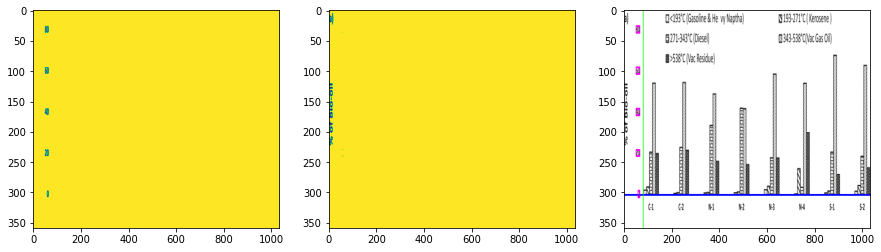

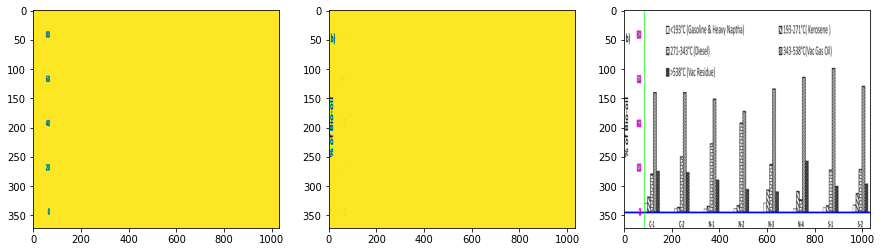

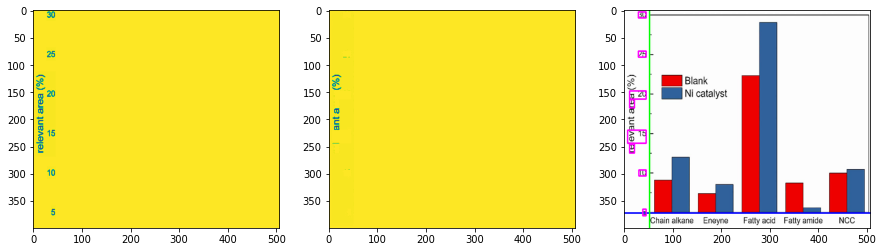

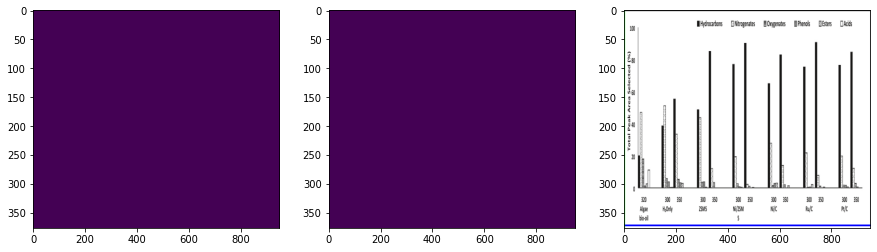

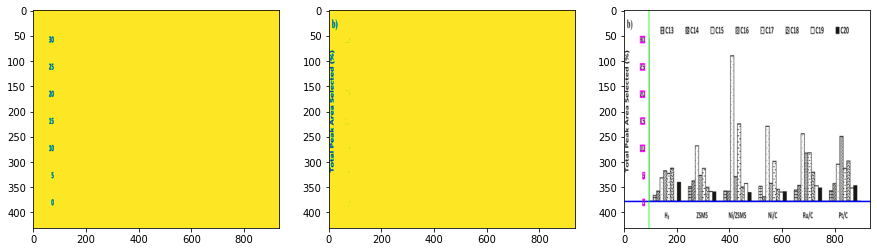

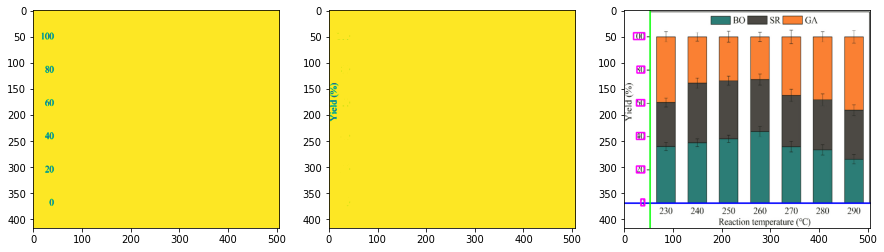

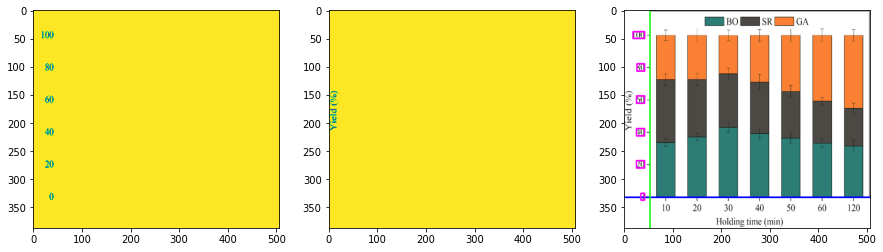

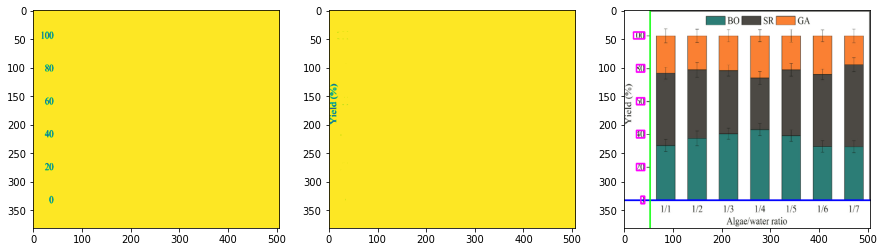

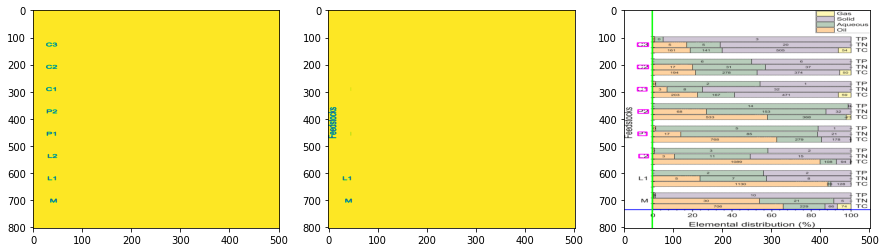

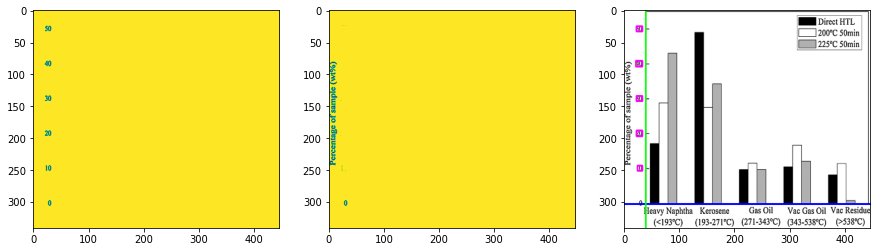

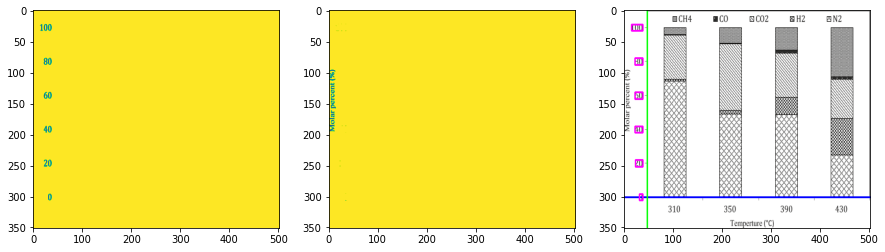

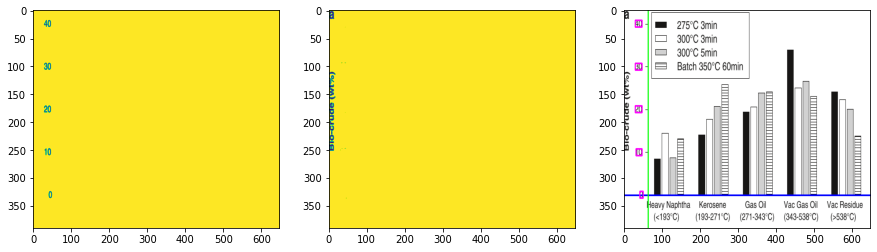

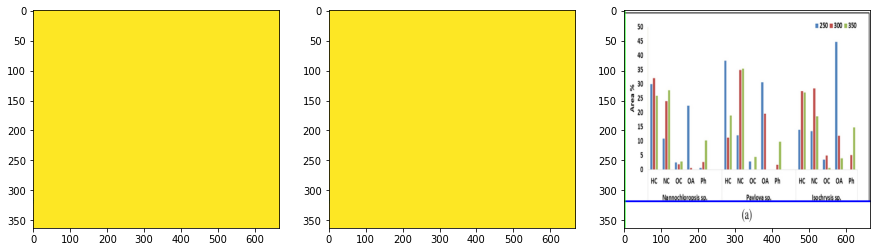

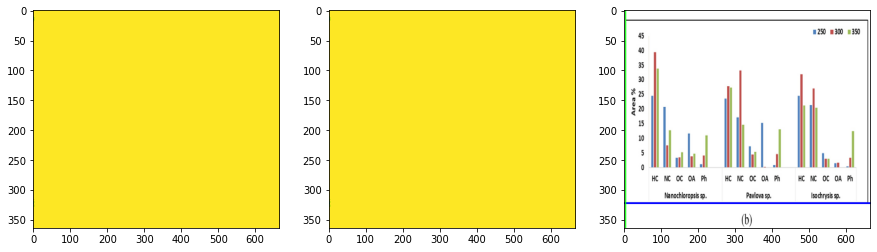

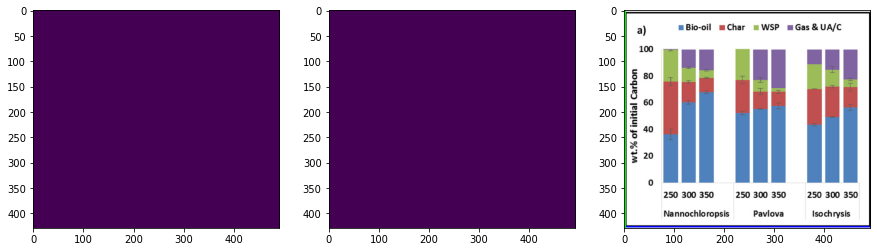

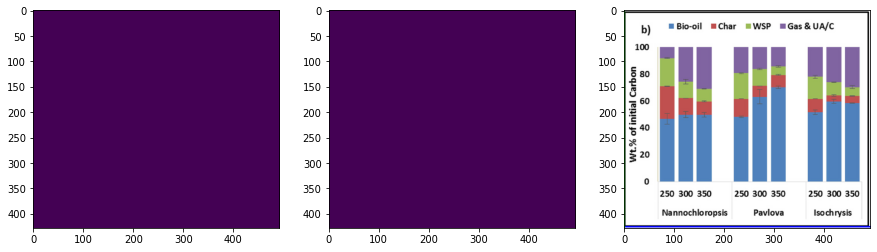

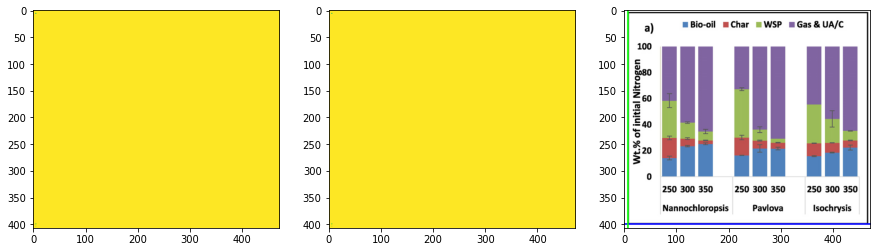

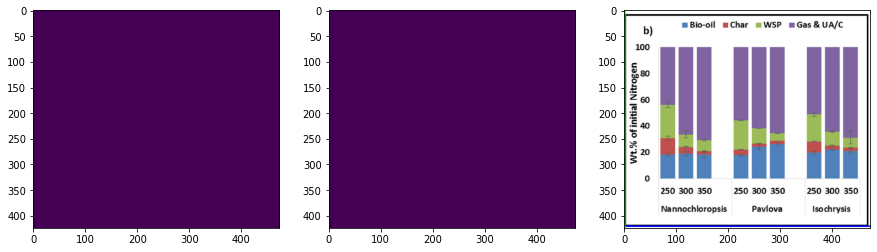

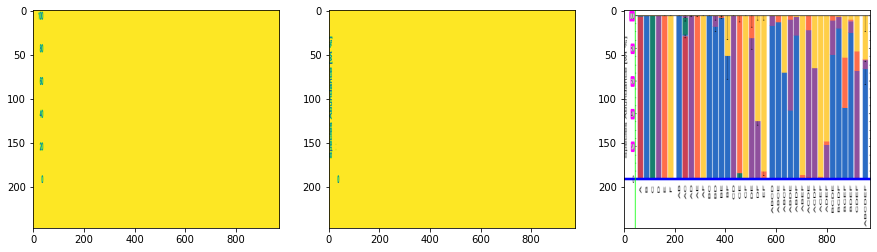

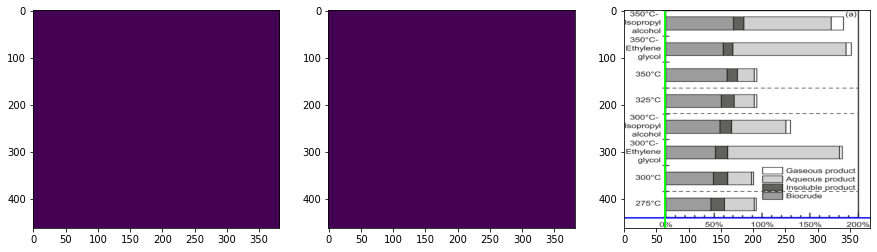

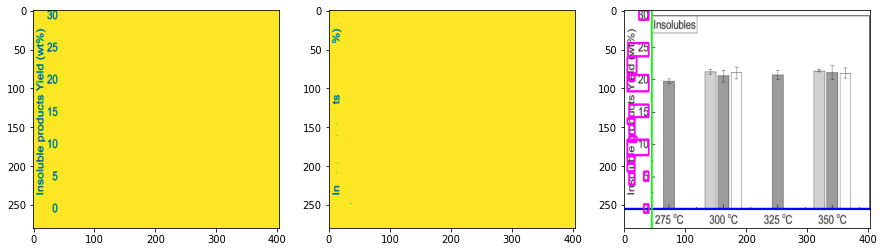

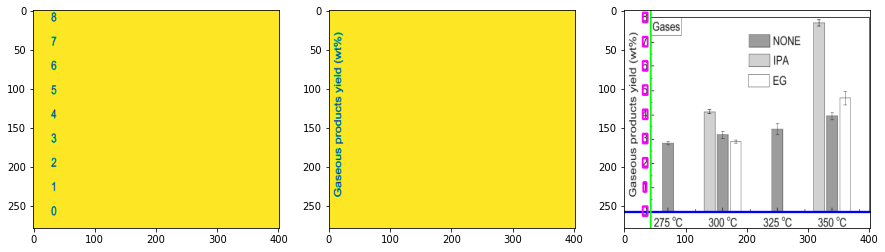

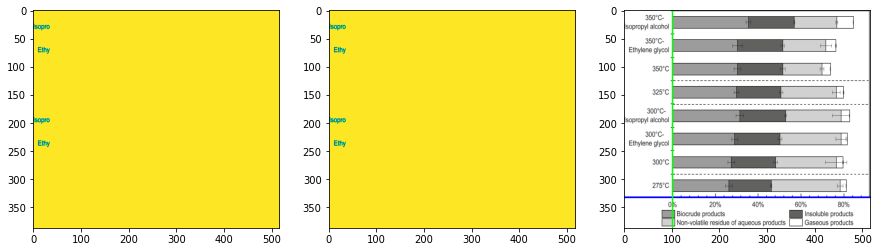

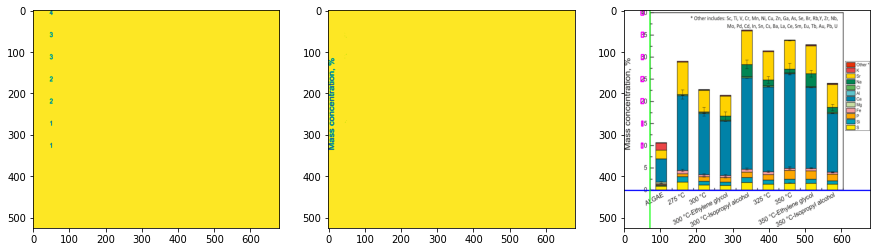

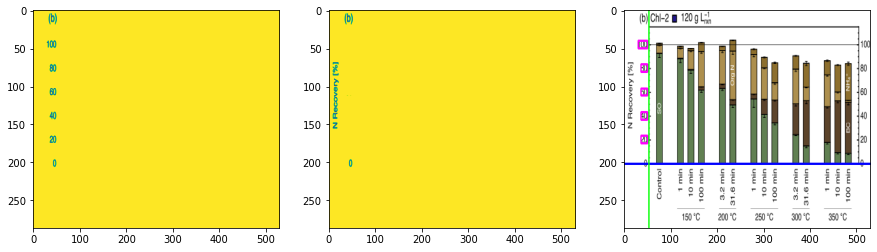

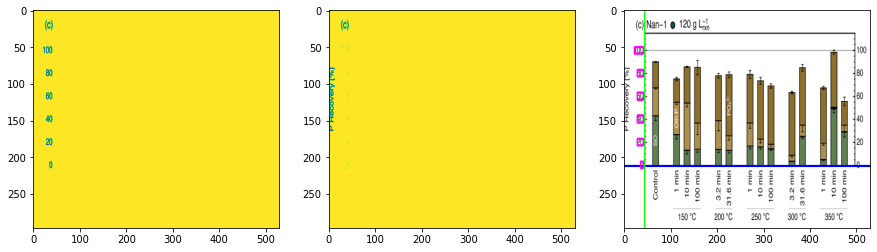

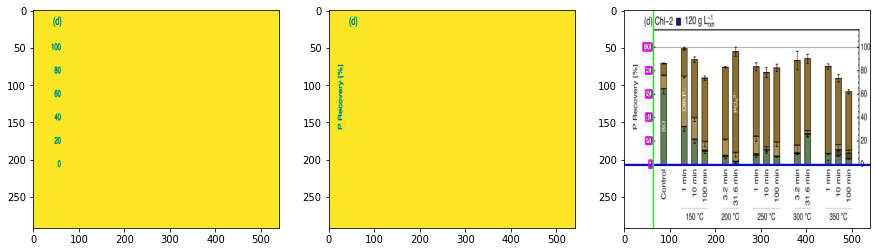

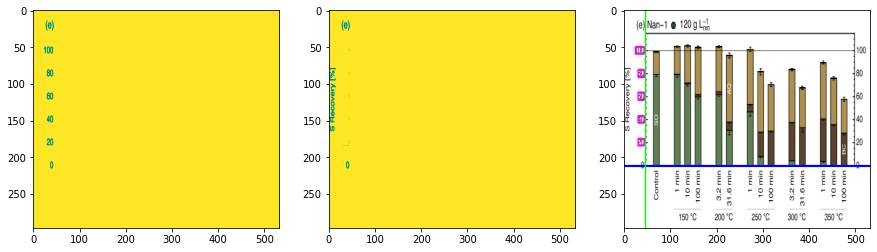

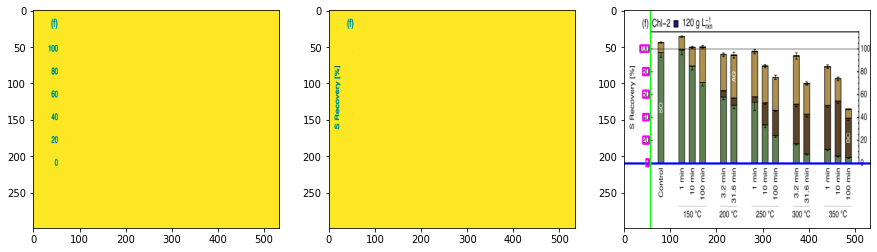

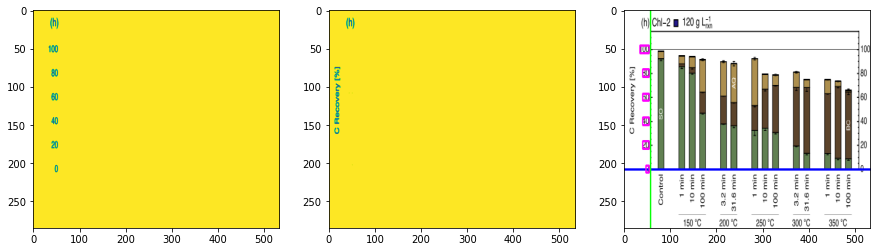

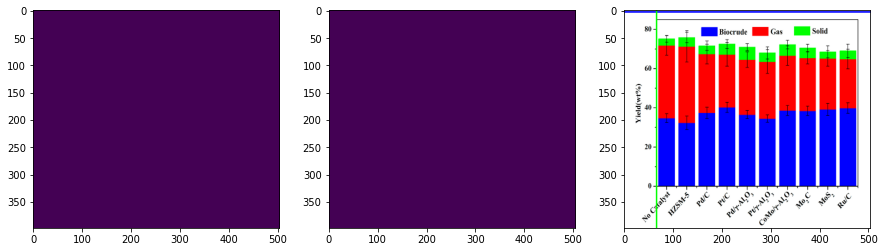

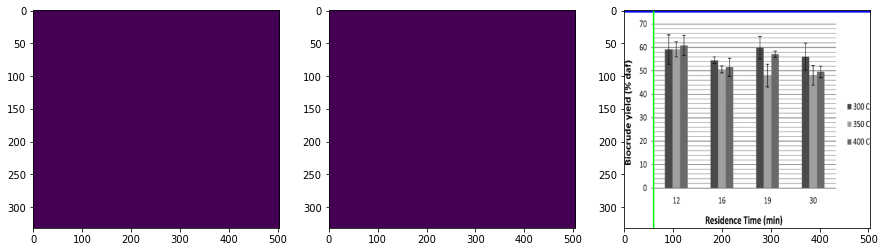

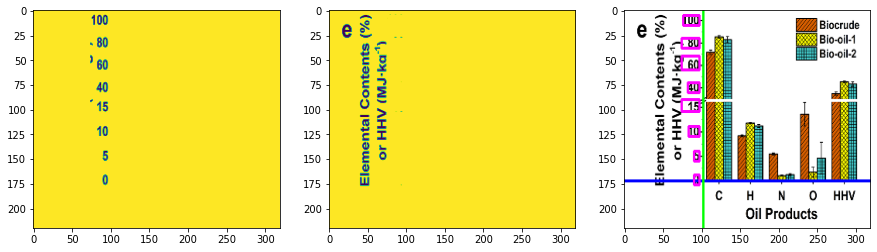

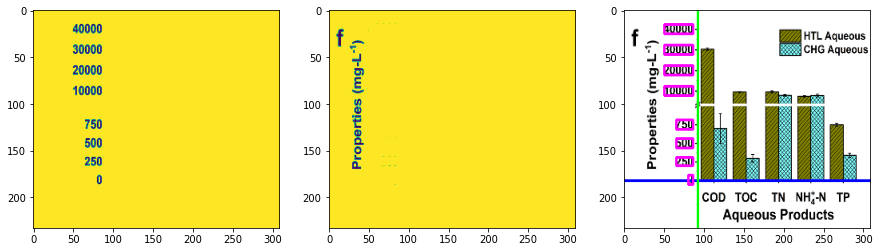

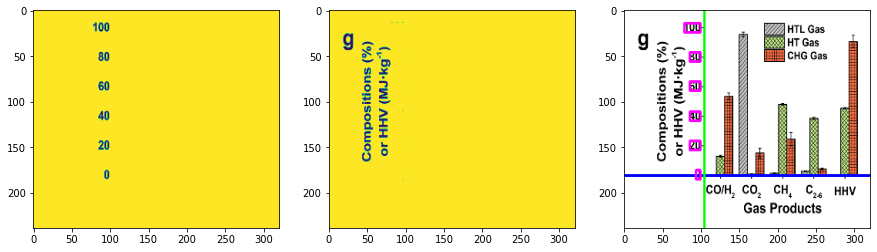

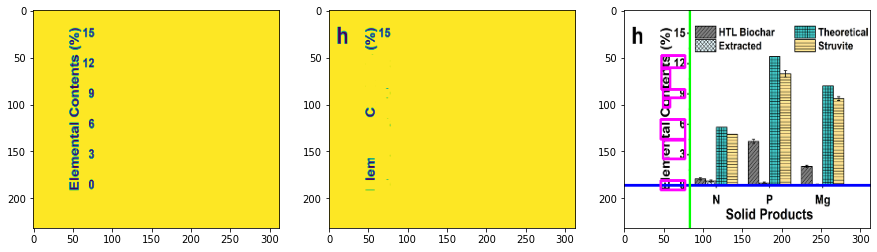

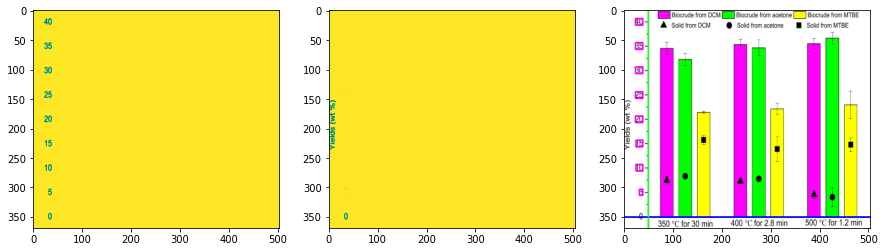

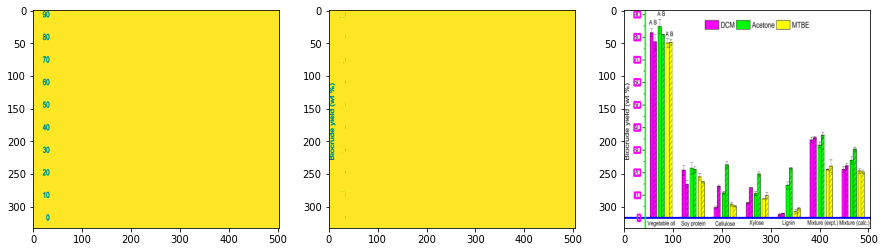

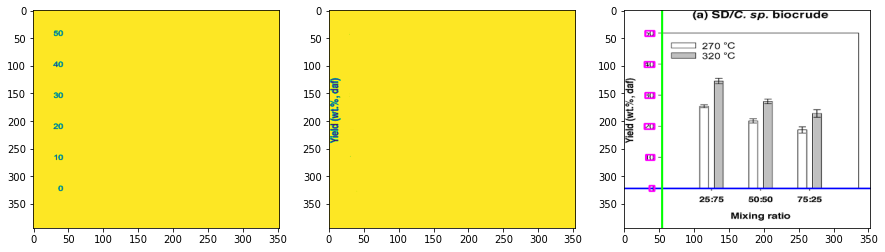

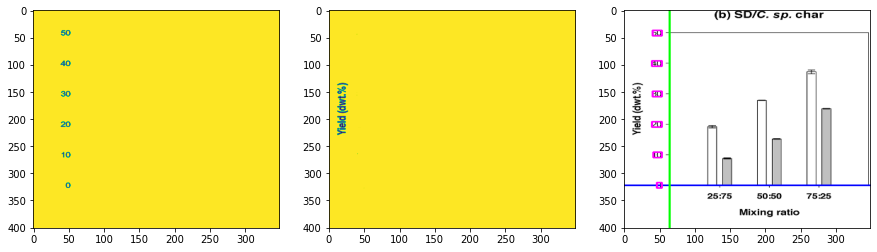

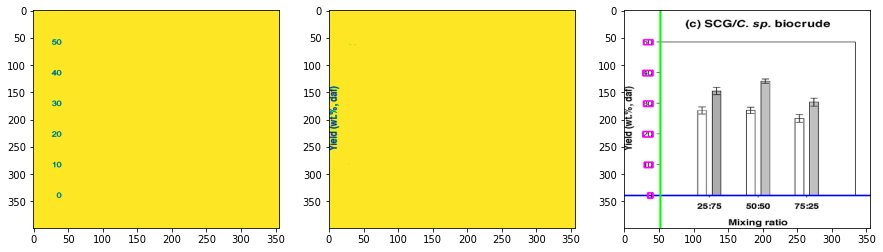

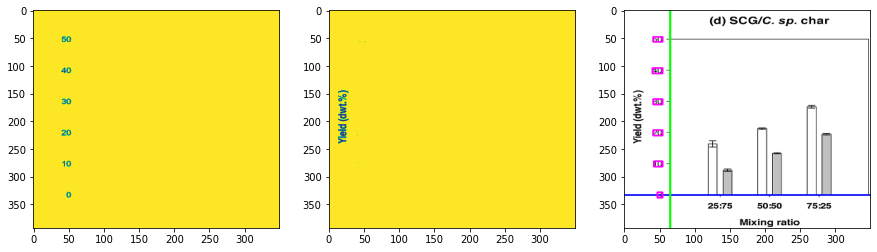

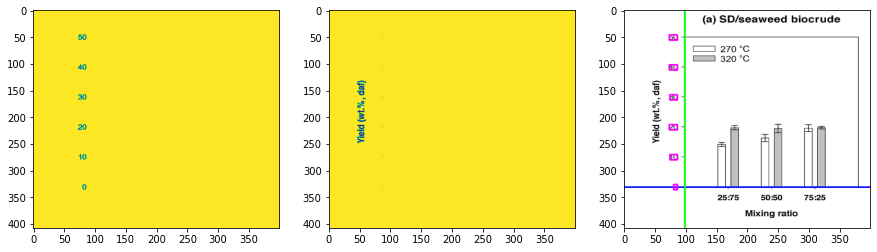

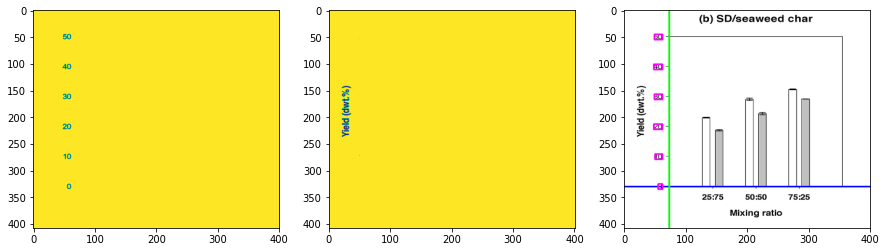

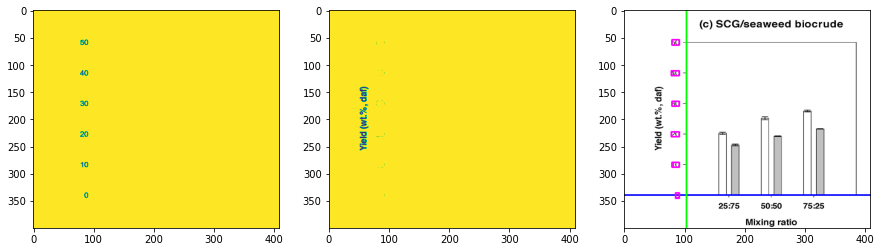

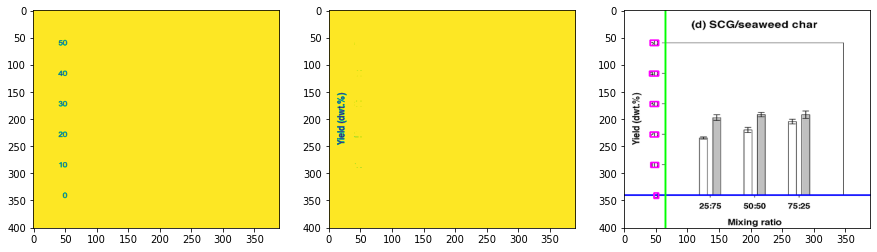

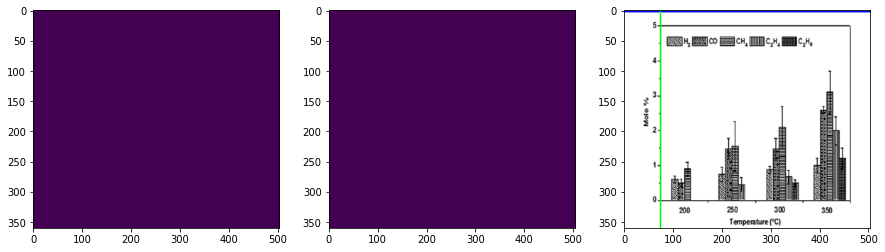

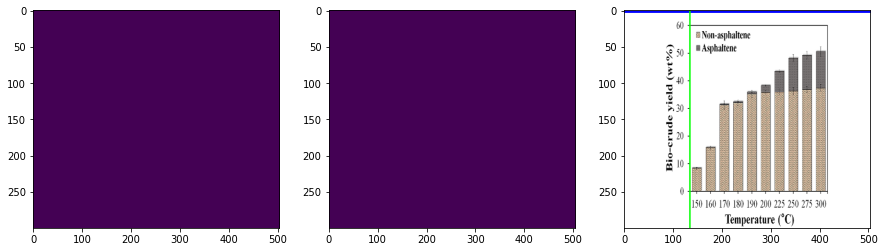

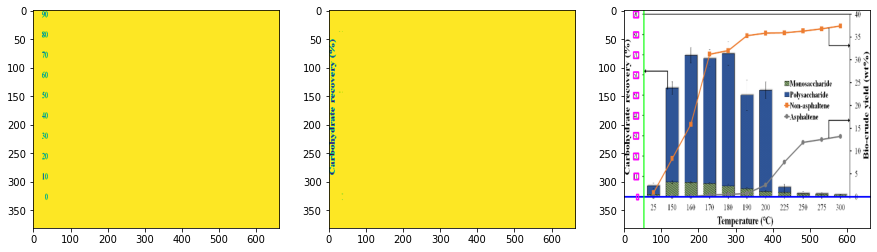

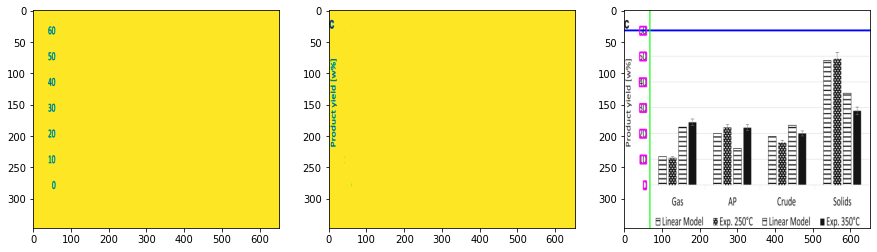

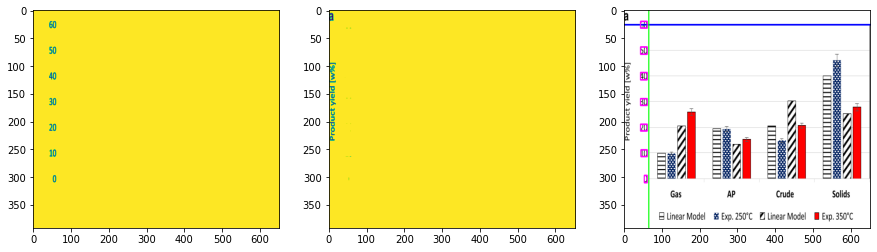

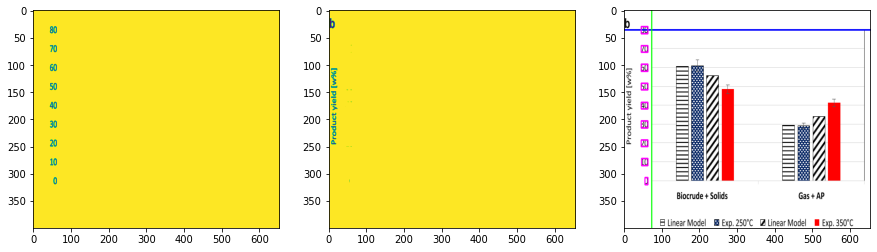

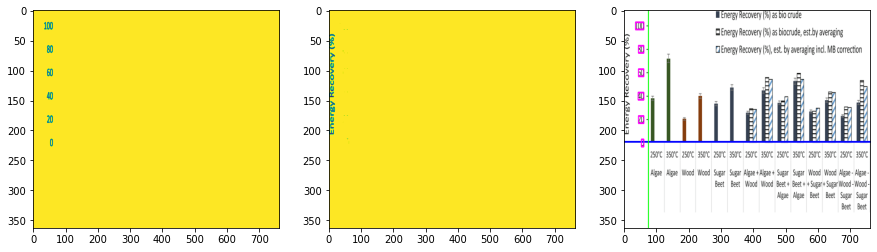

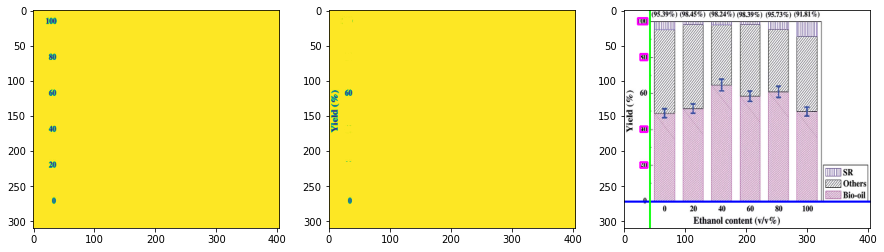

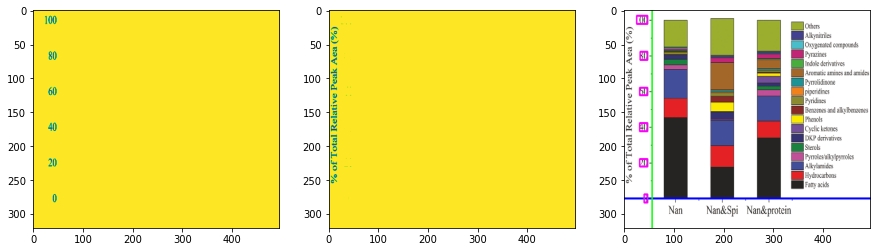

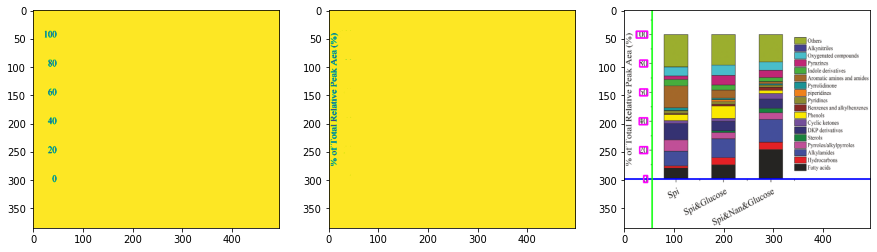

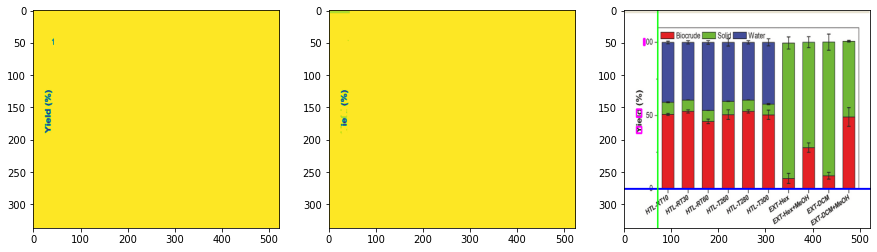

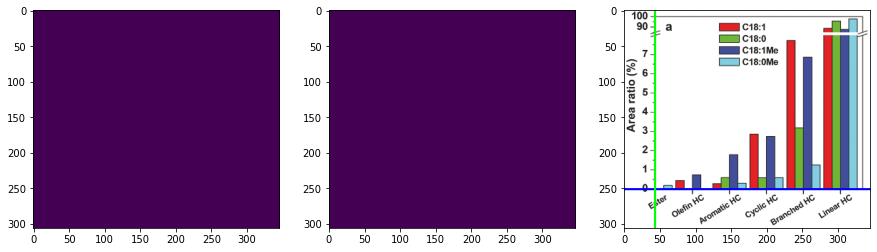

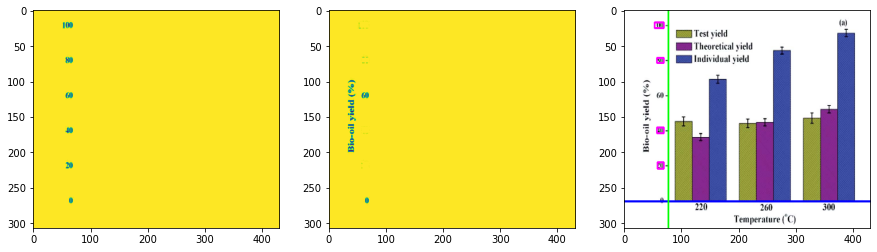

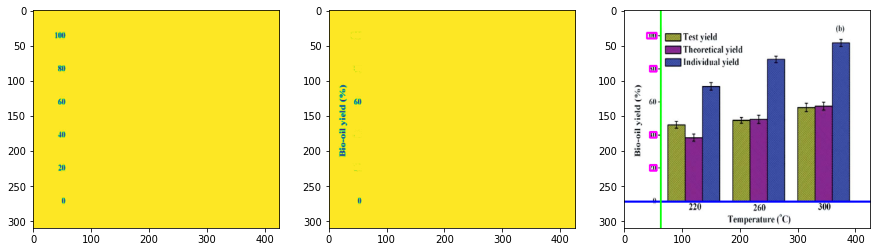

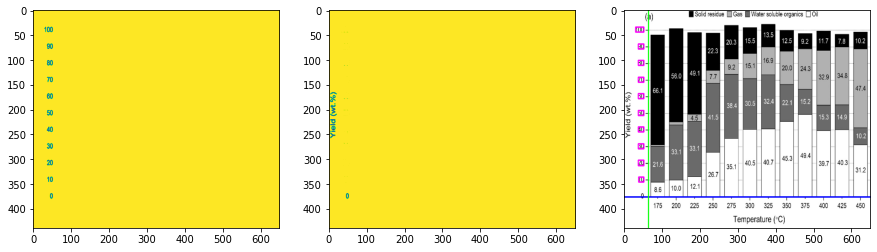

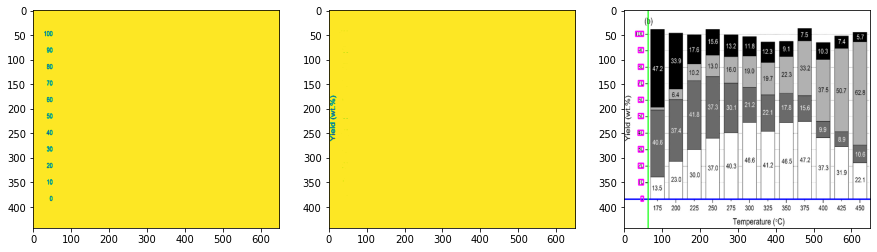

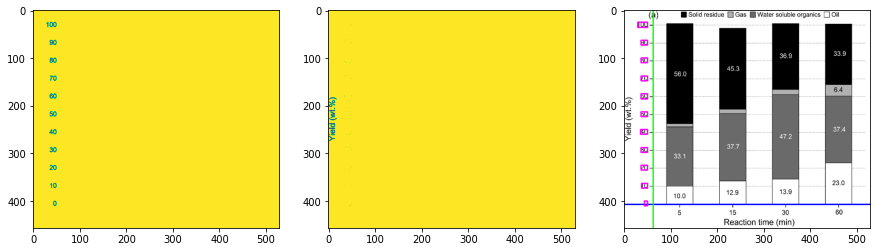

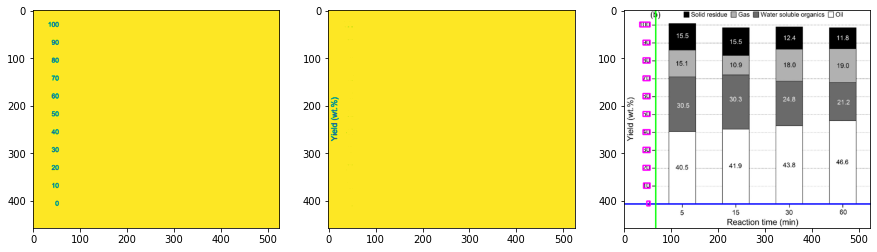

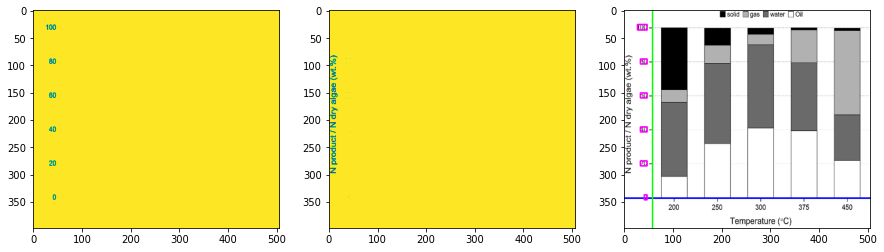

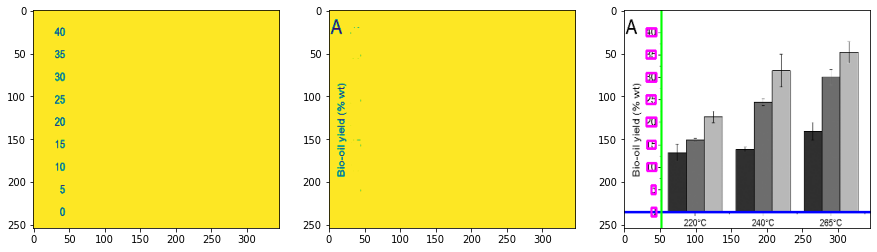

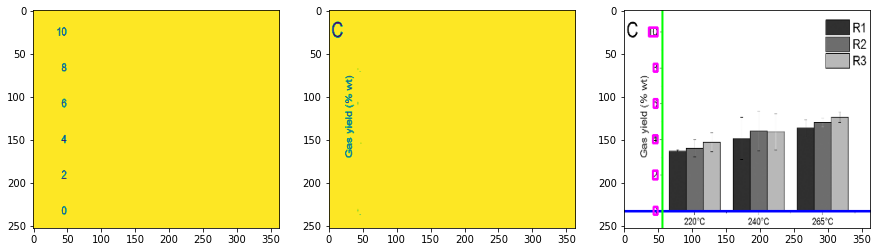

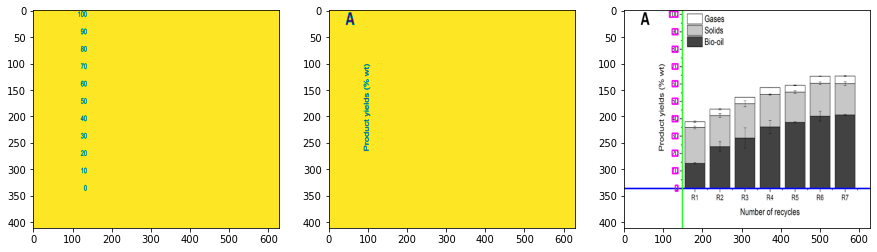

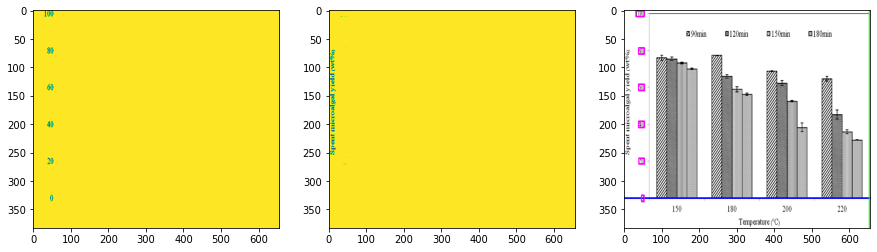

In [22]:
workbook = xlsxwriter.Workbook('FigureData1.xlsx')

for path in Path(img_dir).iterdir():
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):
        if path.name in yValueDict:

            filepath = img_dir + "/" + path.name
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            height, width, channels = image.shape
            xaxis, yaxis = detectAxes(filepath)
            y_text, y_labels = [], []

            for (x1, y1, x2, y2) in [xaxis]:
                xaxis = (x1, y1, x2, y2)

            for (x1, y1, x2, y2) in [yaxis]:
                yaxis = (x1, y1, x2, y2)
                
            rcParams['figure.figsize'] = 15, 4
            fig, ax = plt.subplots(1, 3)

            # Make a backward pass to skip the ticks
            gray = maskImageBackwardPass(filepath, yaxis[0])

            # Processing the image so that the contours are drawn to labels and text
            ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
            thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)
            rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
            thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)

            contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = contours[0] if len(contours) == 2 else contours[1]
            rects = [cv2.boundingRect(contour) for contour in contours]
            print("number of contours: ", len(contours))

            image_text = getTextFromImage(filepath, bw=True)
            image, y_labels = getProbableYLabels(image, rects, xaxis, yaxis)
            white_bg = 255 * np.ones_like(gray.copy())

            for (textx, texty, w, h) in y_labels:
                roi = gray[texty:texty + h, textx:textx + w]
                white_bg[texty:texty + h, textx:textx + w] = roi

            # Get y-labels
            y_labels_list = getTextFromImageArray(white_bg, 'y-labels')
            ax[0].imshow(white_bg, aspect = 'auto')

            # Sort bounding rects by y coordinate
            def getYFromRect(item):
                return item[1][1]

            # Whiten y-labels and get y-text
            y_labels_list.sort(key = getYFromRect)
            y_labels = []
            for text, (textx, texty, w, h) in y_labels_list:
                roi = 255 * np.ones_like(gray[texty:texty + h, textx:textx + w])
                gray[texty:texty + h, textx:textx + w] = roi
                y_labels.append(text)

            y_text_list = getTextFromImageArray(gray, 'y-text')

            # Sort bounding rects by x coordinate
            def getXFromRect(item):
                return item[1][0]

            y_text_list.sort(key = getXFromRect)        
            for text, (textx, texty, w, h) in y_text_list:
                y_text.append(text)

            # Get the remaining: x-labels and legends
            image_text = getTextFromImage(filepath, bw=True)
            image, x_labels, _, legends = getProbableLabels(image, image_text, xaxis, yaxis)

            # Write to Excel
            worksheet = workbook.add_worksheet()            
            
            #addToExcel("caption", [urldata[path.name]], 0)
            addToExcel("file name", [path.name[::-4] + ".pdf"], 1)
            addToExcel("x-labels", x_labels, 2)
            addToExcel("y-text", y_text, 3)
            addToExcel("y-labels", y_labels, 4)
            addToExcel("legends", legends, 5)
            
            for col_num, data in enumerate(yValueDict[path.name]):
                print(col_num, data)
                if type(data) != list:
                    worksheet.write(9 + col_num, 0, "Y-values:" + "\n\n" + str(data))
                else:
                    for pos,d in enumerate(data):
                        worksheet.write(9 + col_num, pos, str(d))

            # Print the output here!
            print("file name    :  ", path.name)
            print("x-labels     :  ", x_labels)
            print("y-text       :  ", y_text)
            print("y-labels     :  ", y_labels)
            print("legends      :  ", legends)
            print("Y- Values    :  ", ' '.join([str(elem) for elem in yValueDict[path.name]]), end = "\n\n")

            for (x1, y1, x2, y2) in [xaxis]:
                cv2.line(image, (x1, y1), (x2, y2),  (0, 0, 255), 2)

            for (x1, y1, x2, y2) in [yaxis]:
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            for text, (textx, texty, w, h) in y_labels_list:
                cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)

            ax[1].imshow(gray, aspect = 'auto')
            ax[2].imshow(image, aspect = 'auto')

            # Insert the image
            worksheet.insert_image('J21', filepath)

# Close the excel workbook!
workbook.close()